In [1]:
# Import Packaes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning packages
from sklearn.preprocessing import StandardScaler  # Maybe use MinMaxScaler?
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score


# Prevents Pandas Copy Warning
pd.set_option("mode.copy_on_write", True)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

## Exploratory Data Analysis

In [ ]:
folder_path = "./data/"
train_identity = pd.read_csv(f"{folder_path}train_identity.csv")
train_transaction = pd.read_csv(f"{folder_path}train_transaction.csv")

# let's combine the data and work with the whole dataset
train = pd.merge(train_transaction, train_identity, on="TransactionID", how="left")

In [3]:
print(
    f"Train transaction dataset has {train_transaction.shape[0]} rows and {train_transaction.shape[1]} columns."
)
print(
    f"Train identity dataset has {train_identity.shape[0]} rows and {train_identity.shape[1]} columns."
)
print(f"Merged Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.")

train.head()

Train transaction dataset has 590540 rows and 394 columns.
Train identity dataset has 144233 rows and 41 columns.
Merged Train dataset has 590540 rows and 434 columns.


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


After loading in the dataset we observe the following:

- There are 590,540 observation and 434 variables.

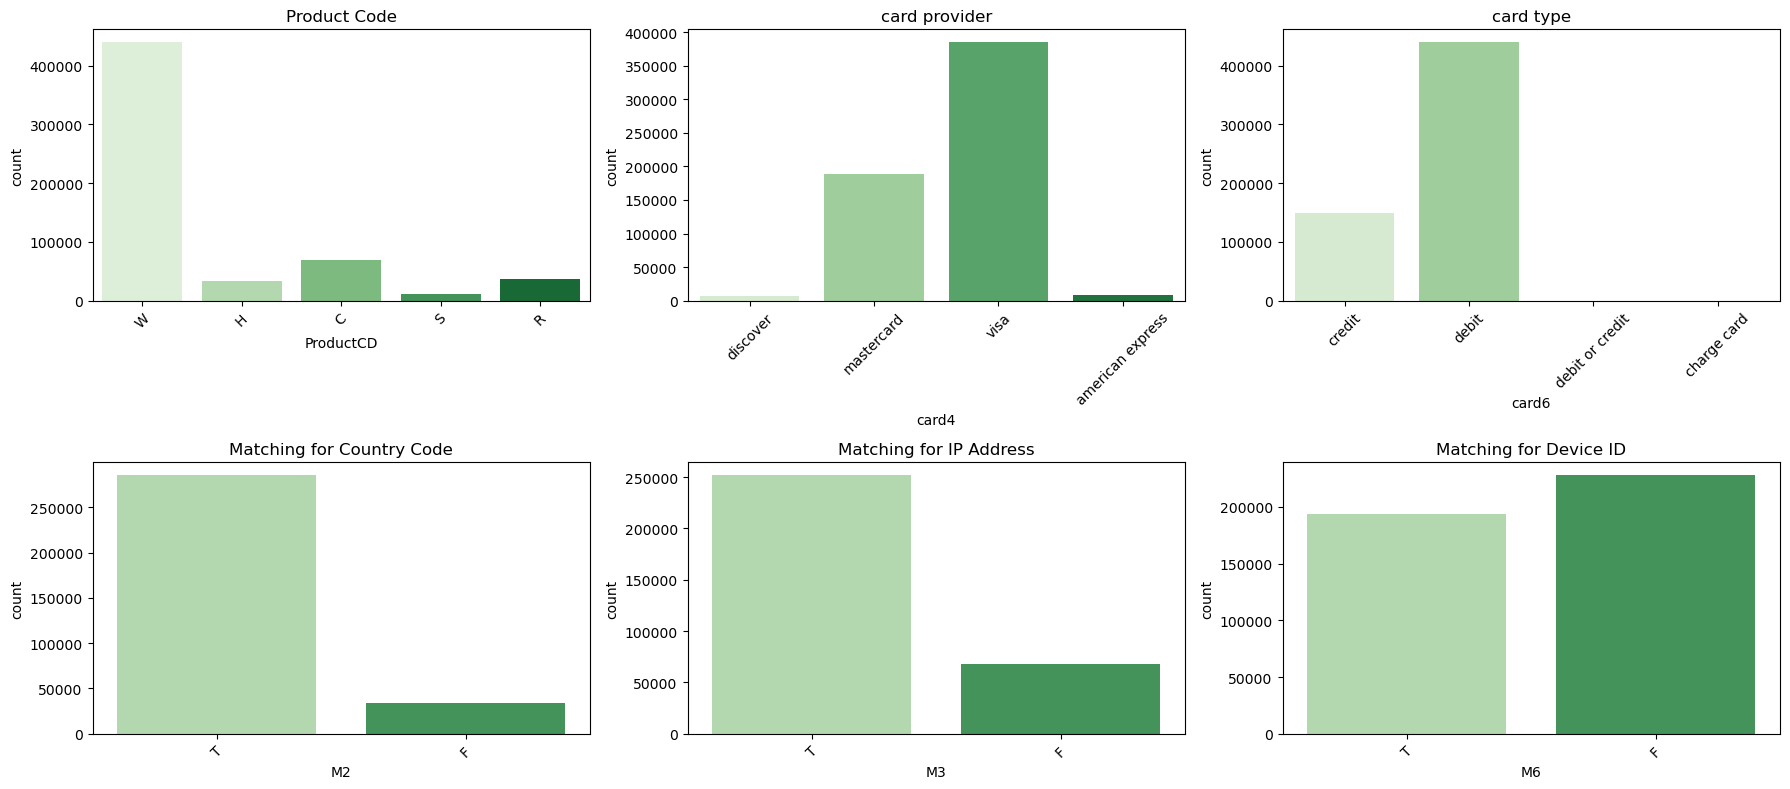

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# List of categorical features to plot
features = ["ProductCD", "card4", "card6", "M2", "M3", "M6"]

# List of names for each feature (match order with features list)
names = [
    "Product Code",
    "card provider",
    "card type",
    "Matching for Country Code",
    "Matching for IP Address",
    "Matching for Device ID",
]

# Assuming the train data is already loaded as 'train'
# Set the figure size with a smaller height
plt.figure(figsize=(18, 8))  # Reduced height

# Create subplots to plot each feature's distribution with 6 columns
for i, (feature, name) in enumerate(zip(features, names), 1):
    plt.subplot(2, 3, i)  # Arrange subplots in 2 rows and 6 columns
    sns.countplot(
        data=train, x=feature, hue=feature, palette="Greens", legend=False
    )  # Set hue and palette
    plt.title(f"{name}")  # Use the descriptive names from the list
    plt.xticks(rotation=45)  # Rotate x labels for readability
    plt.tight_layout()

# Show the plot
plt.show()

/var/folders/ws/5_ksfmcx633ccphy2fv3shbw0000gn/T/ipykernel_2528/1207571173.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  axes2 = sns.barplot(


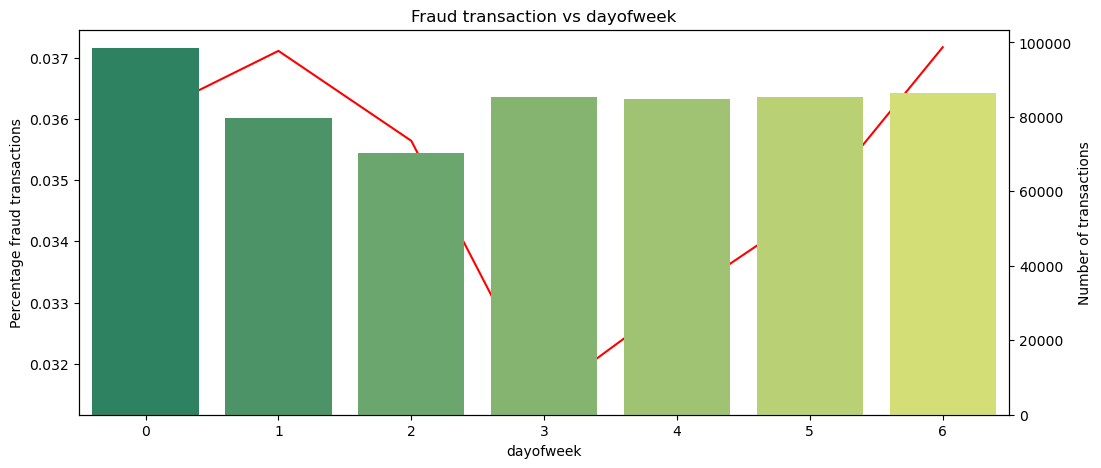

In [5]:
train["dayofweek"] = (train["TransactionDT"] // (60 * 60 * 24) - 1) % 7
tmp = (
    train[["isFraud", "dayofweek"]]
    .groupby(by=["dayofweek"])
    .mean()
    .reset_index()
    .rename(columns={"isFraud": "Percentage fraud transactions"})
)

tmp_count = (
    train[["TransactionID", "dayofweek"]]
    .groupby(by=["dayofweek"])
    .count()
    .reset_index()
    .rename(columns={"TransactionID": "Number of transactions"})
)
tmp = tmp.merge(tmp_count, on=["dayofweek"])


fig, axes = plt.subplots(figsize=(12, 5))
axes = sns.lineplot(
    x=tmp["dayofweek"], y=tmp["Percentage fraud transactions"], color="r"
)
axes2 = axes.twinx()
axes2 = sns.barplot(
    x=tmp["dayofweek"], y=tmp["Number of transactions"], palette="summer"
)
axes.set_title("Fraud transaction vs dayofweek")
plt.show()

/var/folders/ws/5_ksfmcx633ccphy2fv3shbw0000gn/T/ipykernel_2528/3050223313.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  axes2 = sns.barplot(x=tmp["hour"], y=tmp["Number of transactions"], palette="summer")


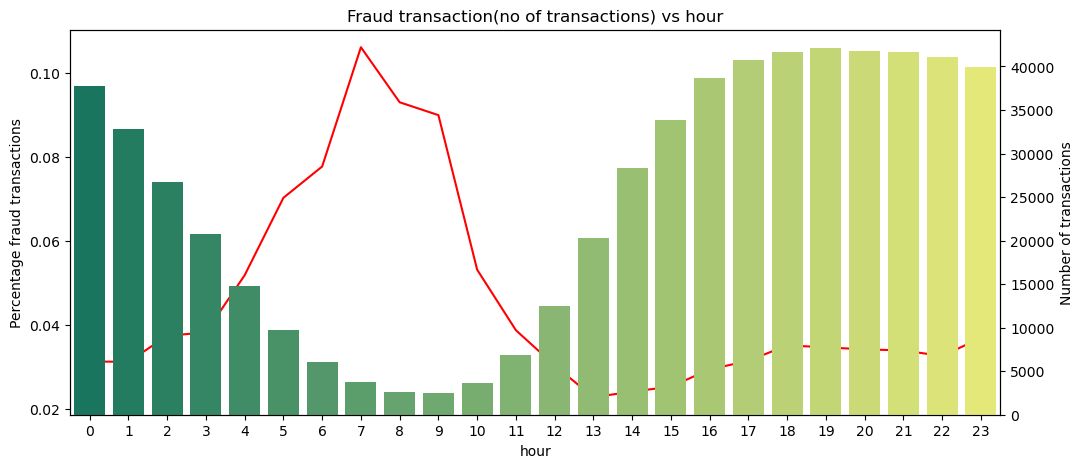

In [6]:
train["hour"] = (train["TransactionDT"] // (60 * 60)) % 24
tmp = (
    train[["isFraud", "hour"]]
    .groupby(by=["hour"])
    .mean()
    .reset_index()
    .rename(columns={"isFraud": "Percentage fraud transactions"})
)

tmp_count = (
    train[["TransactionID", "hour"]]
    .groupby(by=["hour"])
    .count()
    .reset_index()
    .rename(columns={"TransactionID": "Number of transactions"})
)
tmp = tmp.merge(tmp_count, on=["hour"])


fig, axes = plt.subplots(figsize=(12, 5))
axes = sns.lineplot(x=tmp["hour"], y=tmp["Percentage fraud transactions"], color="r")
axes2 = axes.twinx()
axes2 = sns.barplot(x=tmp["hour"], y=tmp["Number of transactions"], palette="summer")
axes.set_title("Fraud transaction(no of transactions) vs hour")
plt.show()

/var/folders/ws/5_ksfmcx633ccphy2fv3shbw0000gn/T/ipykernel_2528/3840721613.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dff_notfraud["TransactionAmt"], ax=axes[0], label="not fraud")
/var/folders/ws/5_ksfmcx633ccphy2fv3shbw0000gn/T/ipykernel_2528/3840721613.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750b

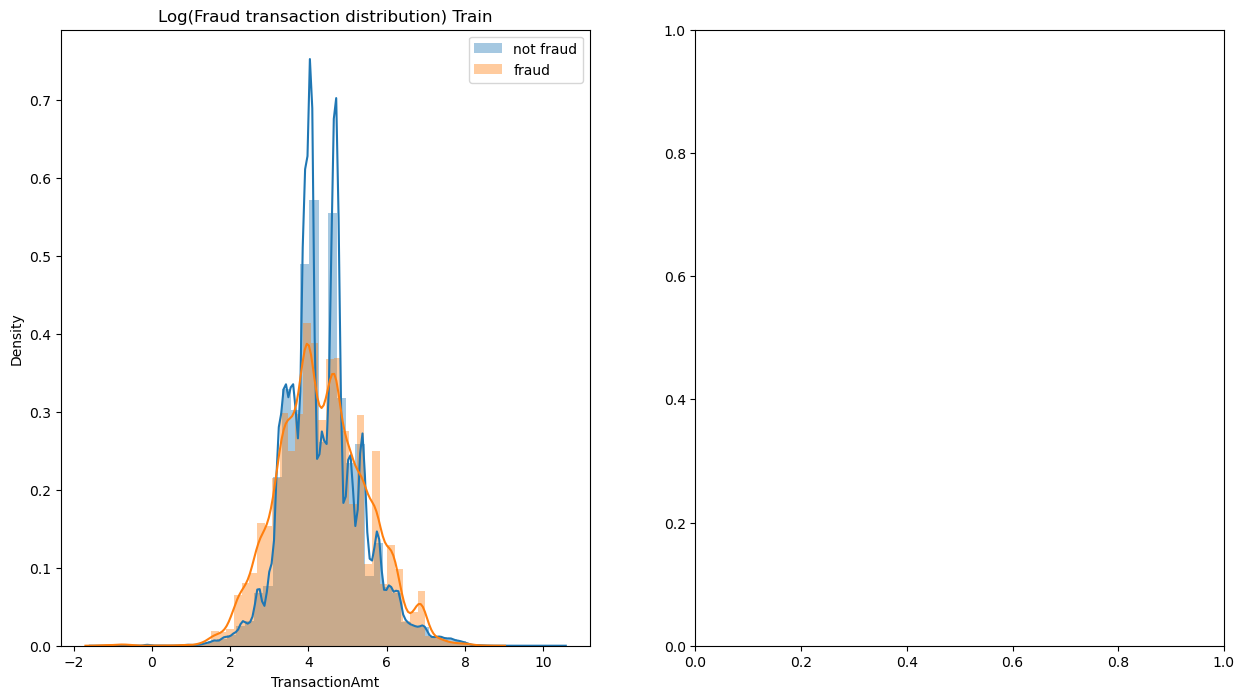

In [7]:
# test_amt = np.log(df_test[['TransactionAmt']])

dff_fraud = train[train["isFraud"] == 1]
dff_notfraud = train[train["isFraud"] == 0]

dff_fraud["TransactionAmt"] = np.log(dff_fraud["TransactionAmt"])
dff_notfraud["TransactionAmt"] = np.log(dff_notfraud["TransactionAmt"])


fig, axes = plt.subplots(1, 2, figsize=(15, 8))
sns.distplot(dff_notfraud["TransactionAmt"], ax=axes[0], label="not fraud")
sns.distplot(dff_fraud["TransactionAmt"], ax=axes[0], label="fraud")
axes[0].title.set_text("Log(Fraud transaction distribution) Train")
axes[0].legend()

# sns.distplot(test_amt,ax=axes[1])
# axes[1].title.set_text('Log(Fraud transaction distribution) Test')
plt.show()

In [8]:
"""
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(10,8))
sns.boxplot(dff_notfraud['TransactionAmt'],ax=axes[0])
axes[0].title.set_text('Log(Non Fraud transaction distribution)')
axes[0].set(xlim=(0, 12))
sns.boxplot(dff_fraud['TransactionAmt'],ax=axes[1],color=colors[2])
axes[1].title.set_text('Log(Fraud transaction distribution)')
axes[1].set(xlim=(0, 12))
plt.show()

print('Mean transaction amt for fraud is {:.4f} ie, {:.4f} dollars'.format(dff_fraud['TransactionAmt'].mean(),np.exp(dff_fraud['TransactionAmt'].mean())))
print('Mean transaction amt for non-fraud is {:.4f} ie, {:.4f} dollars'.format(dff_notfraud['TransactionAmt'].mean(),np.exp(dff_notfraud['TransactionAmt'].mean())))

print('Median transaction amt for fraud is {:.4f}  ie, {:.4f} dollars'.format(dff_fraud['TransactionAmt'].median(),np.exp(dff_fraud['TransactionAmt'].median())))
print('Median transaction amt for non-fraud is {:.4f}  ie, {:.4f} dollars'.format(dff_notfraud['TransactionAmt'].median(),np.exp(dff_notfraud['TransactionAmt'].median())))
"""

"\nfig, axes = plt.subplots(nrows=2, ncols=1,figsize=(10,8))\nsns.boxplot(dff_notfraud['TransactionAmt'],ax=axes[0])\naxes[0].title.set_text('Log(Non Fraud transaction distribution)')\naxes[0].set(xlim=(0, 12))\nsns.boxplot(dff_fraud['TransactionAmt'],ax=axes[1],color=colors[2])\naxes[1].title.set_text('Log(Fraud transaction distribution)')\naxes[1].set(xlim=(0, 12))\nplt.show()\n\nprint('Mean transaction amt for fraud is {:.4f} ie, {:.4f} dollars'.format(dff_fraud['TransactionAmt'].mean(),np.exp(dff_fraud['TransactionAmt'].mean())))\nprint('Mean transaction amt for non-fraud is {:.4f} ie, {:.4f} dollars'.format(dff_notfraud['TransactionAmt'].mean(),np.exp(dff_notfraud['TransactionAmt'].mean())))\n\nprint('Median transaction amt for fraud is {:.4f}  ie, {:.4f} dollars'.format(dff_fraud['TransactionAmt'].median(),np.exp(dff_fraud['TransactionAmt'].median())))\nprint('Median transaction amt for non-fraud is {:.4f}  ie, {:.4f} dollars'.format(dff_notfraud['TransactionAmt'].median(),np.exp

In [8]:
def top_missing_cols(df, n=10, thresh=80):
    """
    returns missing columns in dataframe with missing values percent > thresh
    if n=None. It will gave whole dataframe with missing values percent > thresh
    """

    dff = (df.isnull().sum() / df.shape[0]) * 100
    dff = dff.reset_index()
    dff.columns = ["col", "missing_percent"]
    dff = dff.sort_values(by=["missing_percent"], ascending=False).reset_index(
        drop=True
    )
    print(
        f"There are {df.isnull().any().sum()} columns in this dataset with missing values."
    )
    print(
        f'There are {dff[dff["missing_percent"] > thresh].shape[0]} columns with missing percent values than {thresh}%'
    )
    if n:
        return dff.head(n)
    else:
        return dff

In [10]:
# from ydata_profiling import ProfileReport

"""

# Generate the profile report
profile = ProfileReport(
    train,
    title="IEEE Fraud Detection Dataset Report",
    minimal=True,  # Faster report with essential information
    explorative=True,  # Adds interactive visualizations for large dataframes
    vars={
        "cat": {
            "check_impact": False,  # Focus on categorical proportions without additional impact metrics
            "count": True,          # Display counts and nulls for categorical variables
        },
        "num": {
            "quantile": True,  # Display quantile-based statistics for continuous variables
        }
    }
)

# Save the report as an HTML file
#profile.to_file("ieee_fraud_detection_report.html")
"""

'\n\n# Generate the profile report\nprofile = ProfileReport(\n    train,\n    title="IEEE Fraud Detection Dataset Report",\n    minimal=True,  # Faster report with essential information\n    explorative=True,  # Adds interactive visualizations for large dataframes\n    vars={\n        "cat": {\n            "check_impact": False,  # Focus on categorical proportions without additional impact metrics\n            "count": True,          # Display counts and nulls for categorical variables\n        },\n        "num": {\n            "quantile": True,  # Display quantile-based statistics for continuous variables\n        }\n    }\n)\n\n# Save the report as an HTML file\n#profile.to_file("ieee_fraud_detection_report.html")\n'

In [4]:
import pandas as pd

# import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Separate target and drop 'TransactionID' column
y = train["isFraud"]
X = train.drop(columns=["isFraud", "TransactionID"])

# Step 1: Filter out columns with >25% missing values
missing_percentages = X.isnull().mean() * 100
X_filtered = X.loc[:, missing_percentages <= 25]

# Step 2: Impute missing values before encoding
for column in X_filtered.columns:
    if (
        X_filtered[column].dtype == "float64" or X_filtered[column].dtype == "int64"
    ):  # Continuous variables
        X_filtered[column] = X_filtered[column].fillna(X_filtered[column].median())
    else:  # Categorical variables
        X_filtered[column] = X_filtered[column].fillna(X_filtered[column].mode()[0])

# Step 3: Encode categorical features
X_encoded = pd.get_dummies(X_filtered, drop_first=True)

# Step 4: Split the data for training (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# Step 5: Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

           feature  importance
0    TransactionDT    0.065103
1   TransactionAmt    0.052296
2            card1    0.043005
8               C1    0.039530
3            card2    0.033782
6            addr1    0.030894
20             C13    0.030855
9               C2    0.024104
21             C14    0.022953
18             C11    0.020612
82             V87    0.017923
5            card5    0.016585
19             C12    0.016464
24             D15    0.016204
13              C6    0.015066


C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_9676\524818869.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rf_top_features, y="feature", x="importance", palette="Greens_d")


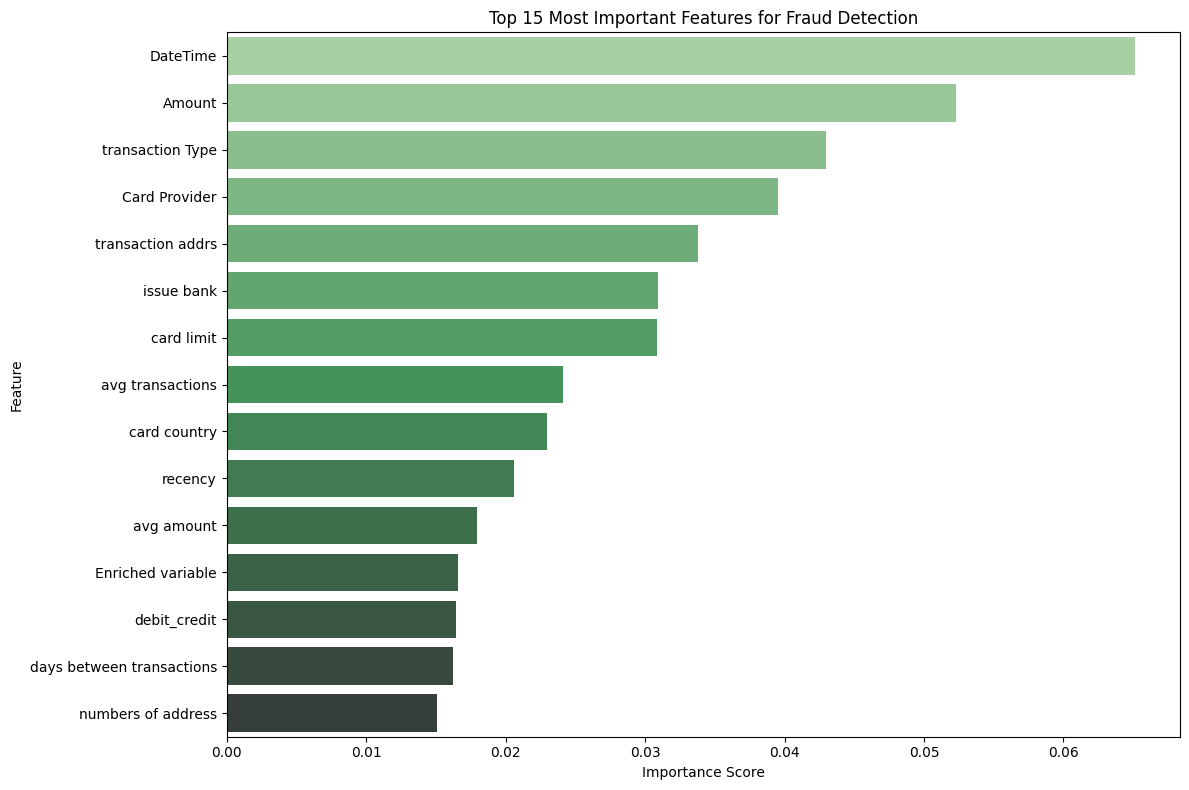

In [5]:
# Step 6: Calculate feature importances
importances = rf.feature_importances_
feature_names = X_encoded.columns


# Create a DataFrame with feature importances
importance_df = pd.DataFrame({"feature": feature_names, "importance": importances})

# Sort by importance and select the top 25 features
rf_top_features = importance_df.sort_values(by="importance", ascending=False).head(15)

print(rf_top_features)
top_features_names = [
    "DateTime",
    "Amount",
    "transaction Type",
    "Card Provider",
    "transaction addrs",
    "issue bank",
    "card limit",
    "avg transactions",
    "card country",
    "recency",
    "avg amount",
    "Enriched variable",
    "debit_credit",
    "days between transactions",
    "numbers of address",
]

# Plot the top 15 features
plt.figure(figsize=(12, 8))
sns.barplot(data=rf_top_features, y="feature", x="importance", palette="Greens_d")

# Replace y-tick labels with `top_features_names`
plt.yticks(ticks=range(len(top_features_names)), labels=top_features_names)

plt.title("Top 15 Most Important Features for Fraud Detection")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

c:\Users\ALEJANDRO\Documents\5. Programming\.virtualenvs\aplt_duke\lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\ALEJANDRO\Documents\5. Programming\.virtualenvs\aplt_duke\lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\ALEJANDRO\Documents\5. Programming\.virtualenvs\aplt_duke\lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.87      0.93    113866
           1       0.20      0.84      0.32      4242

    accuracy                           0.87    118108
   macro avg       0.59      0.86      0.62    118108
weighted avg       0.96      0.87      0.91    118108

Confusion Matrix:
 [[99358 14508]
 [  689  3553]]
ROC AUC Score: 0.9301217259991277


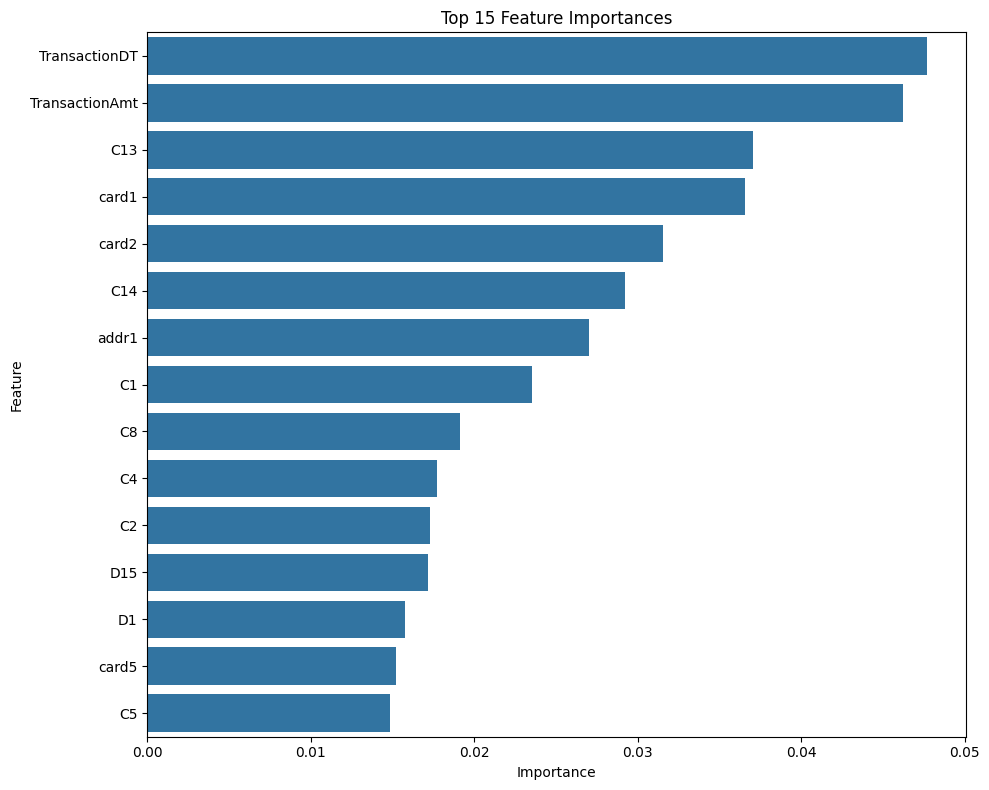

In [7]:
import pandas as pd
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Separate target and drop 'TransactionID' column
y = train["isFraud"]
X = train.drop(columns=["isFraud", "TransactionID"])

# Step 1: Filter out columns with >25% missing values
missing_percentages = X.isnull().mean() * 100
X_filtered = X.loc[:, missing_percentages <= 25]

# Step 2: Impute missing values before encoding
for column in X_filtered.columns:
    if X_filtered[column].dtype in ["float64", "int64"]:  # Continuous variables
        X_filtered[column] = X_filtered[column].fillna(X_filtered[column].median())
    else:  # Categorical variables
        X_filtered[column] = X_filtered[column].fillna(X_filtered[column].mode()[0])

# Step 3: Encode categorical features
X_encoded = pd.get_dummies(X_filtered, drop_first=True)

# Step 4: Split the data for training (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# Step 5: Train a Balanced Random Forest model
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf.fit(X_train, y_train)

# Step 6: Evaluate the model
y_pred = brf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, brf.predict_proba(X_test)[:, 1]))

# Visualize feature importance
brf_feature_importances = pd.DataFrame(
    {"Feature": X_train.columns, "Importance": brf.feature_importances_}
).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=brf_feature_importances.head(15))
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()

brf_top_features = brf_feature_importances.head(15)

In [8]:
print("Random Forest Features (Structure):", rf_top_features[:15])
print("Balanced Random Forest Features (Structure):", brf_top_features[:15])

Random Forest Features (Structure):            feature  importance
0    TransactionDT    0.065103
1   TransactionAmt    0.052296
2            card1    0.043005
8               C1    0.039530
3            card2    0.033782
6            addr1    0.030894
20             C13    0.030855
9               C2    0.024104
21             C14    0.022953
18             C11    0.020612
82             V87    0.017923
5            card5    0.016585
19             C12    0.016464
24             D15    0.016204
13              C6    0.015066
Balanced Random Forest Features (Structure):            Feature  Importance
0    TransactionDT    0.047675
1   TransactionAmt    0.046260
20             C13    0.037028
2            card1    0.036552
3            card2    0.031543
21             C14    0.029213
6            addr1    0.027032
8               C1    0.023524
15              C8    0.019115
11              C4    0.017719
9               C2    0.017267
24             D15    0.017195
22              D1  

In [9]:
# Convert the 'feature' or 'Feature' column into sets
rf_features_set = set(rf_top_features["feature"])  # Random Forest
brf_features_set = set(brf_top_features["Feature"])  # Balanced Random Forest

# Find common and unique features
common_features = rf_features_set & brf_features_set
rf_unique = rf_features_set - brf_features_set
brf_unique = brf_features_set - rf_features_set

# Print the results
print("Common Features:", common_features)
print("Features Unique to Random Forest:", rf_unique)
print("Features Unique to Balanced Random Forest:", brf_unique)

Common Features: {'TransactionAmt', 'C14', 'card1', 'C13', 'card2', 'C2', 'addr1', 'D15', 'TransactionDT', 'C1', 'card5'}
Features Unique to Random Forest: {'C11', 'V87', 'C6', 'C12'}
Features Unique to Balanced Random Forest: {'C5', 'C8', 'D1', 'C4'}


Feature: C14, RF Importance: 0.023044, BRF Importance: 0.029703
Feature: TransactionAmt, RF Importance: 0.052648, BRF Importance: 0.046234
Feature: card1, RF Importance: 0.042754, BRF Importance: 0.036431
Feature: C12, RF Importance: 0.017533, BRF Importance: 0.000000
Feature: addr1, RF Importance: 0.030758, BRF Importance: 0.026890
Feature: D15, RF Importance: 0.016198, BRF Importance: 0.017077
Feature: D1, RF Importance: 0.000000, BRF Importance: 0.015835
Feature: TransactionDT, RF Importance: 0.065149, BRF Importance: 0.047478
Feature: C13, RF Importance: 0.030979, BRF Importance: 0.036276
Feature: C11, RF Importance: 0.020462, BRF Importance: 0.000000
Feature: C6, RF Importance: 0.015584, BRF Importance: 0.000000
Feature: C4, RF Importance: 0.000000, BRF Importance: 0.017226
Feature: card5, RF Importance: 0.016542, BRF Importance: 0.015098
Feature: C2, RF Importance: 0.024637, BRF Importance: 0.018152
Feature: C1, RF Importance: 0.039687, BRF Importance: 0.024881
Feature: C5, RF Im

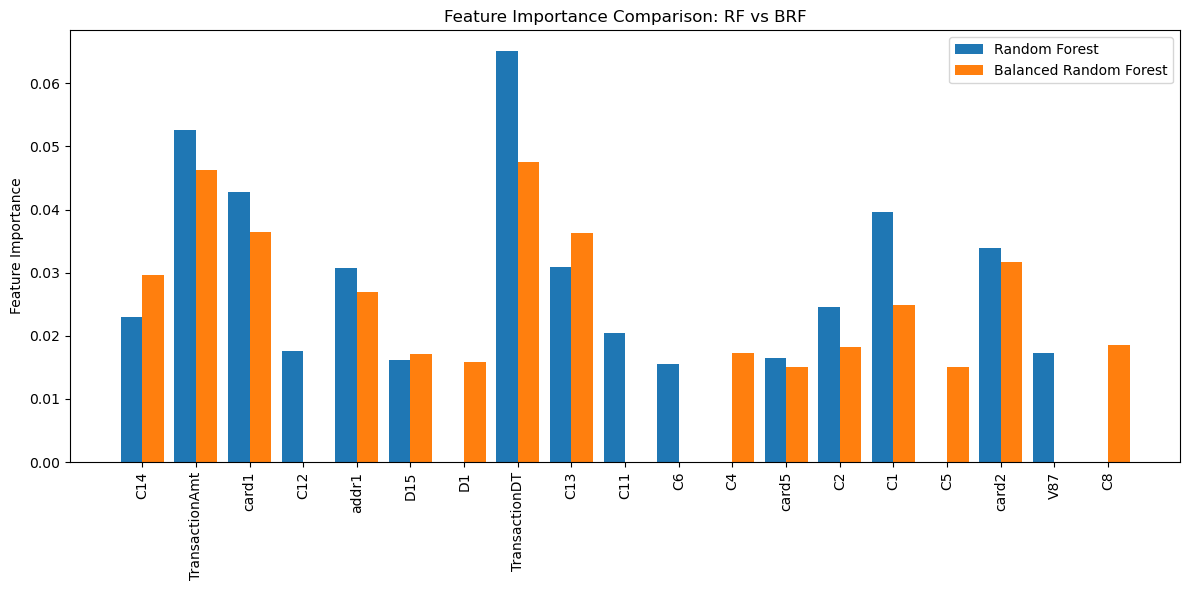

In [ ]:
# Convert feature importance to dictionaries for easy alignment
rf_importances = dict(zip(rf_top_features["feature"], rf_top_features["importance"]))
brf_importances = dict(zip(brf_top_features["Feature"], brf_top_features["Importance"]))

# Combine all features
all_features = rf_features_set | brf_features_set

# Align importance values, using 0 if a feature is not present in one of the models
rf_values = [rf_importances.get(feature, 0) for feature in all_features]
brf_values = [brf_importances.get(feature, 0) for feature in all_features]

# Print comparison
for feature, rf_value, brf_value in zip(all_features, rf_values, brf_values):
    print(
        f"Feature: {feature}, RF Importance: {rf_value:.6f}, BRF Importance: {brf_value:.6f}"
    )

import matplotlib.pyplot as plt
import numpy as np

# Prepare for plotting
features = list(all_features)
indices = np.arange(len(features))

plt.figure(figsize=(12, 6))
plt.bar(indices - 0.2, rf_values, width=0.4, label="Random Forest")
plt.bar(indices + 0.2, brf_values, width=0.4, label="Balanced Random Forest")

plt.xticks(indices, features, rotation=90)
plt.ylabel("Feature Importance")
plt.title("Feature Importance Comparison: RF vs BRF")
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


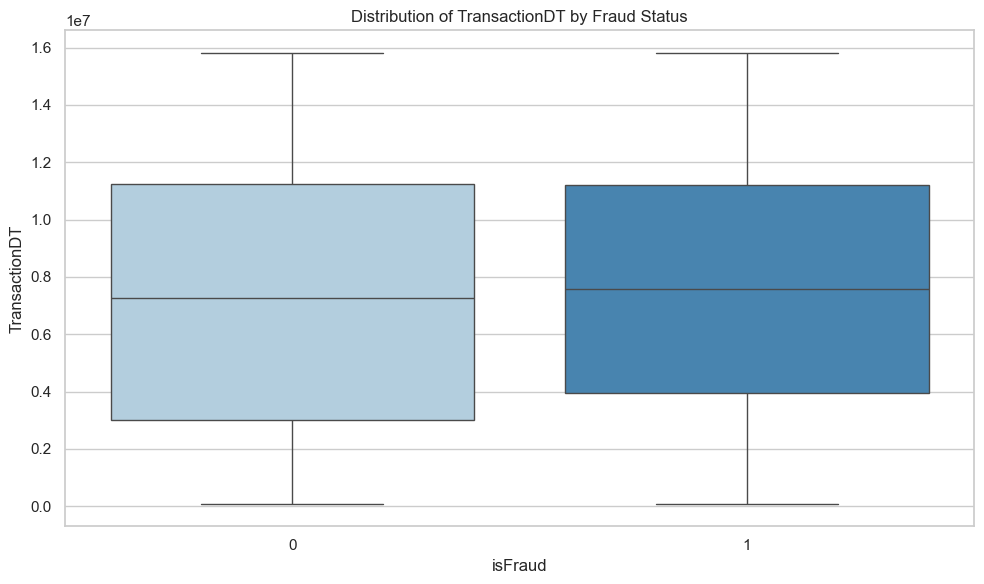

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


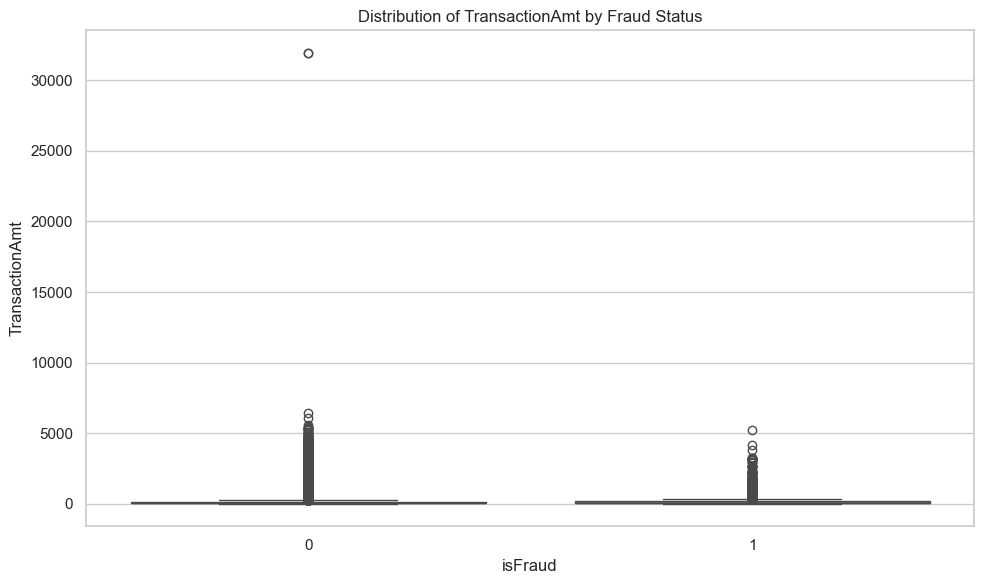

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


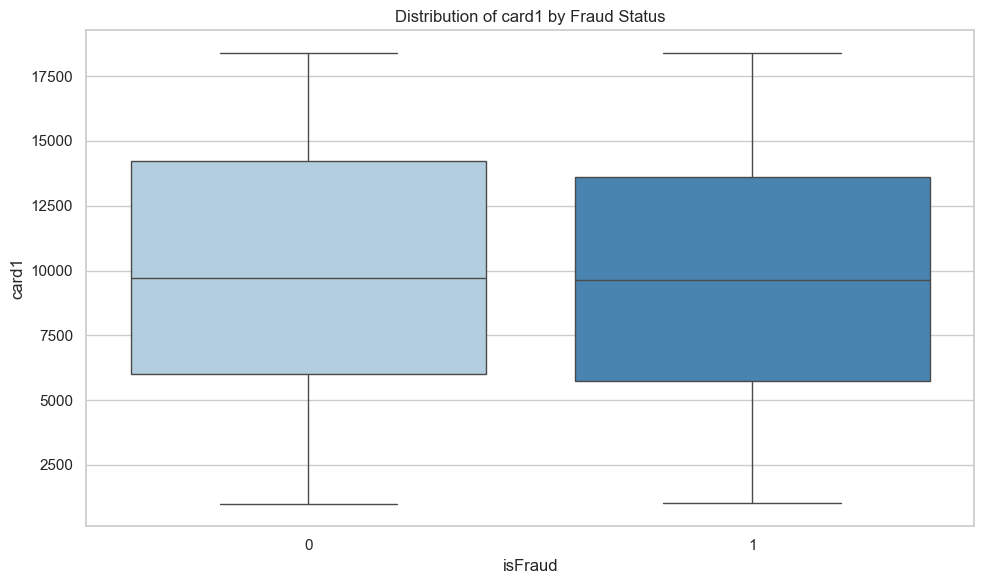

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


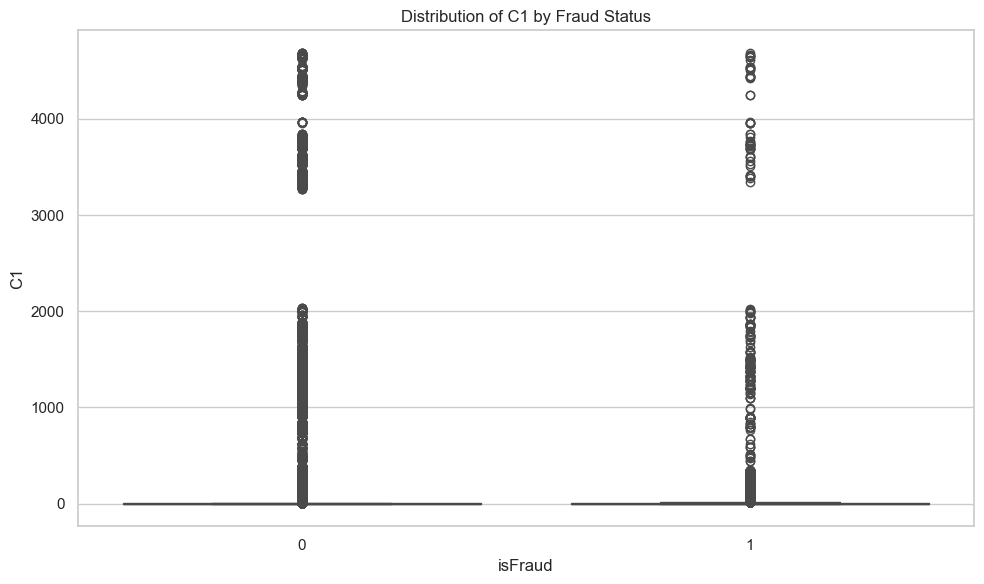

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


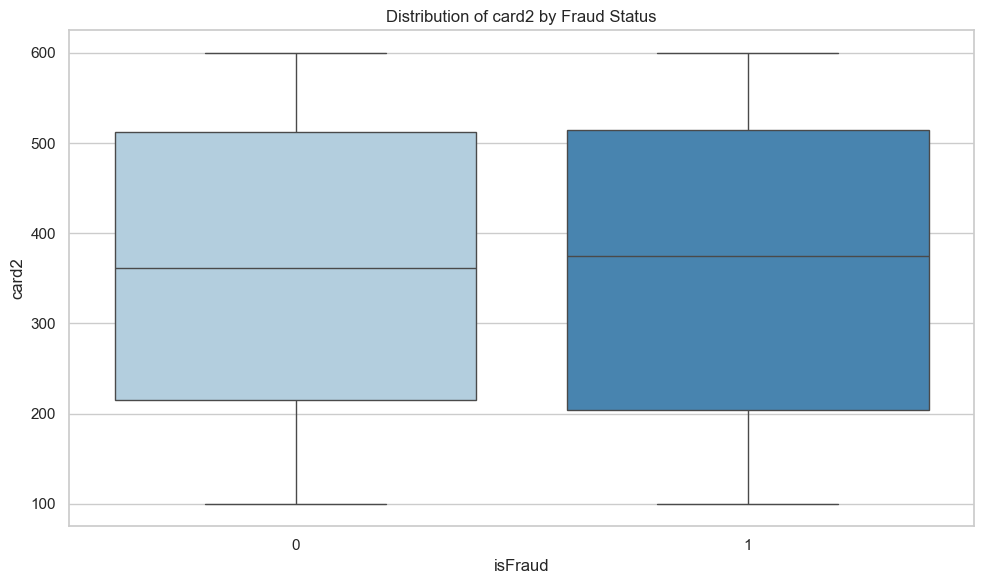

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


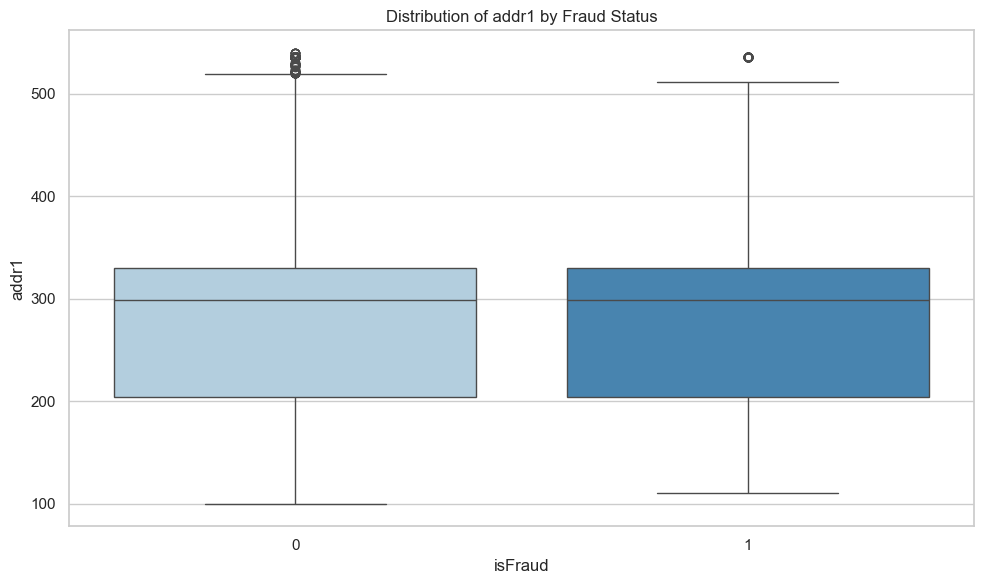

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


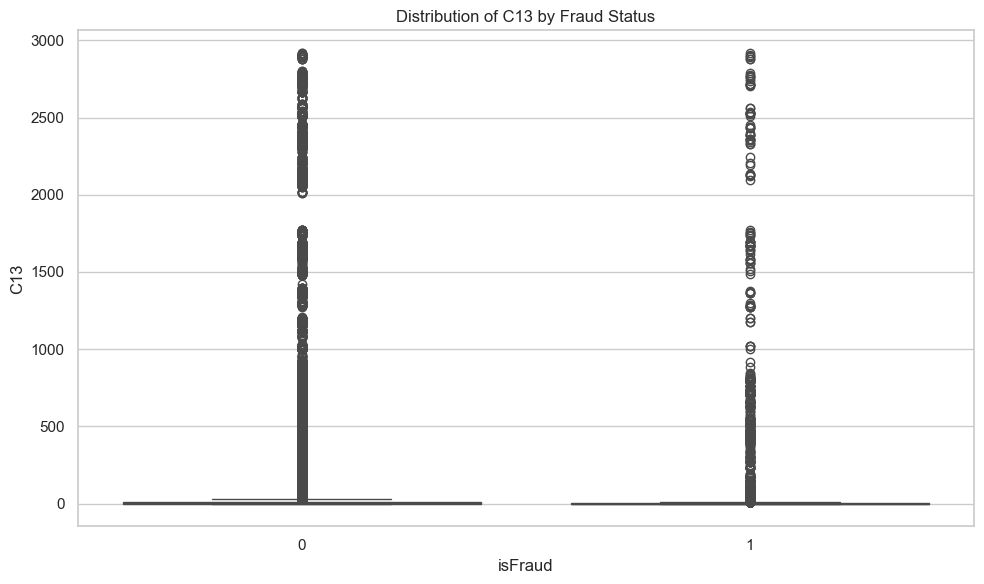

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


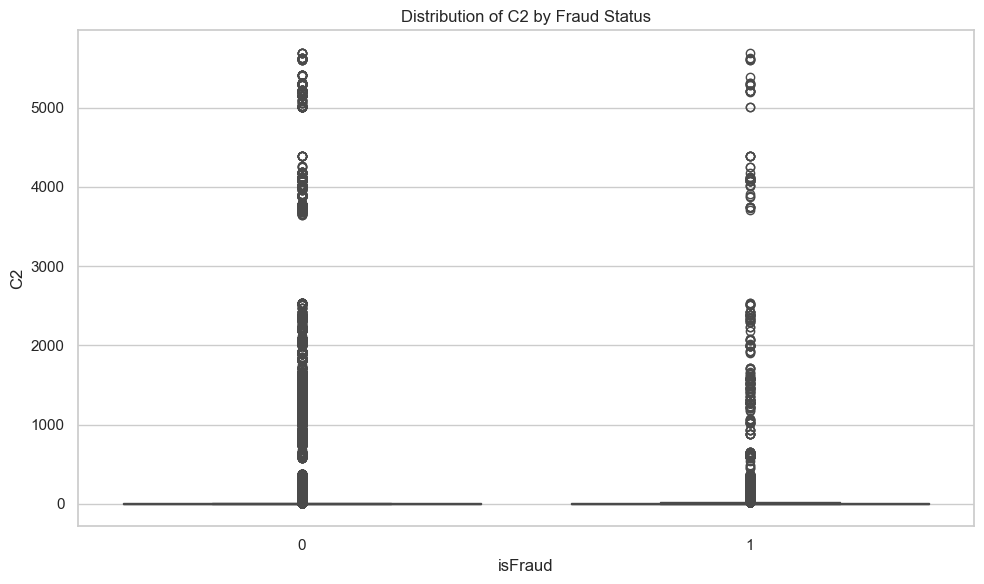

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


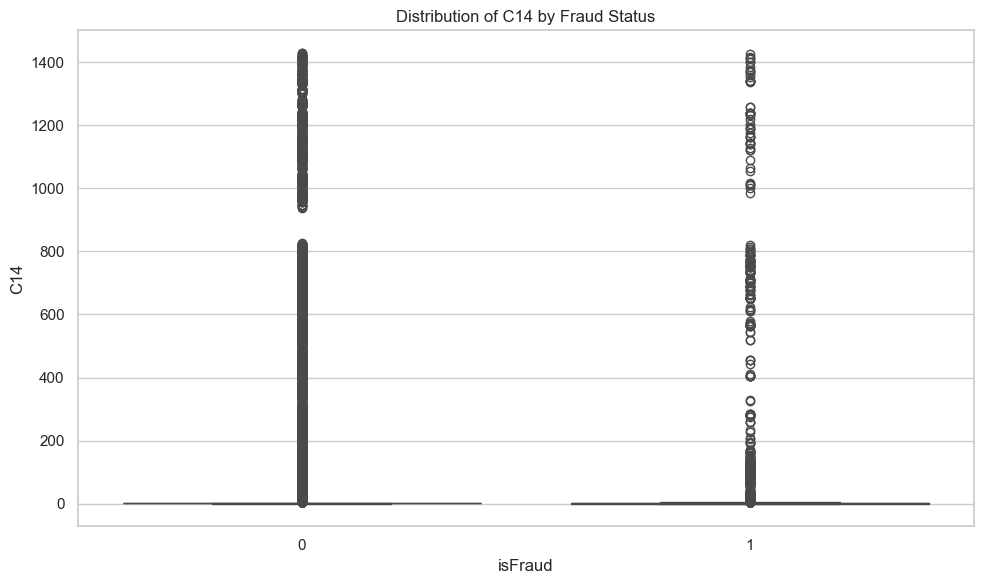

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


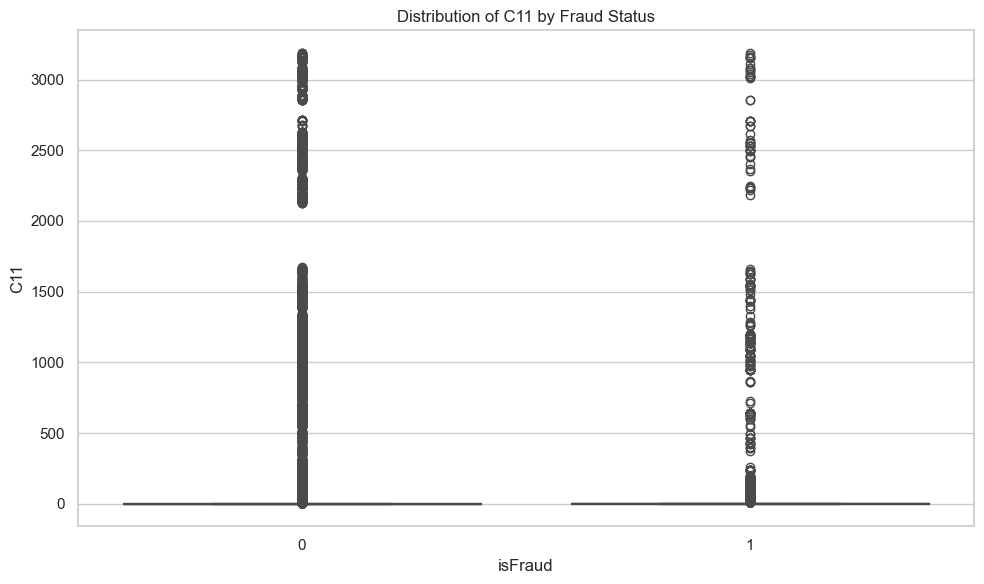

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


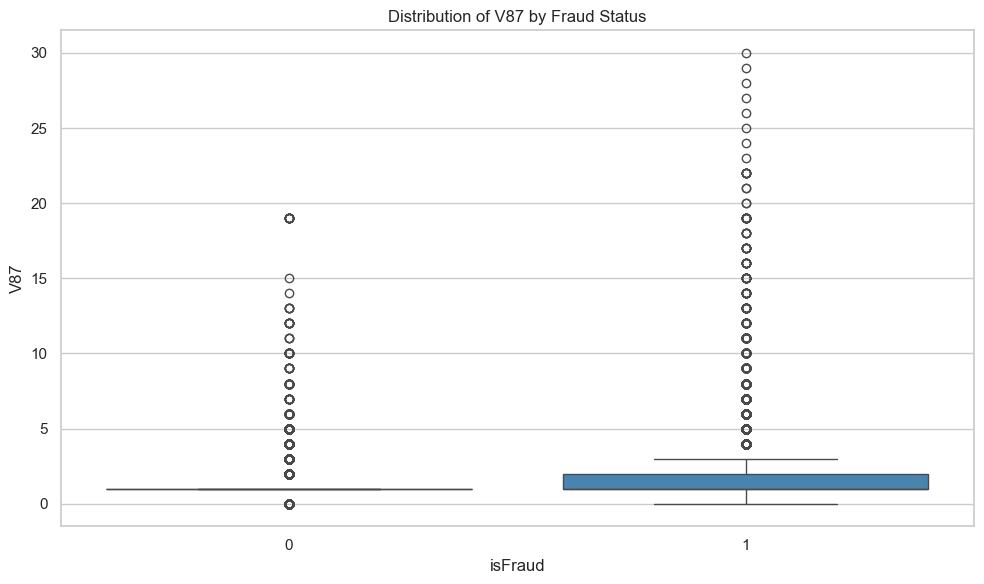

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


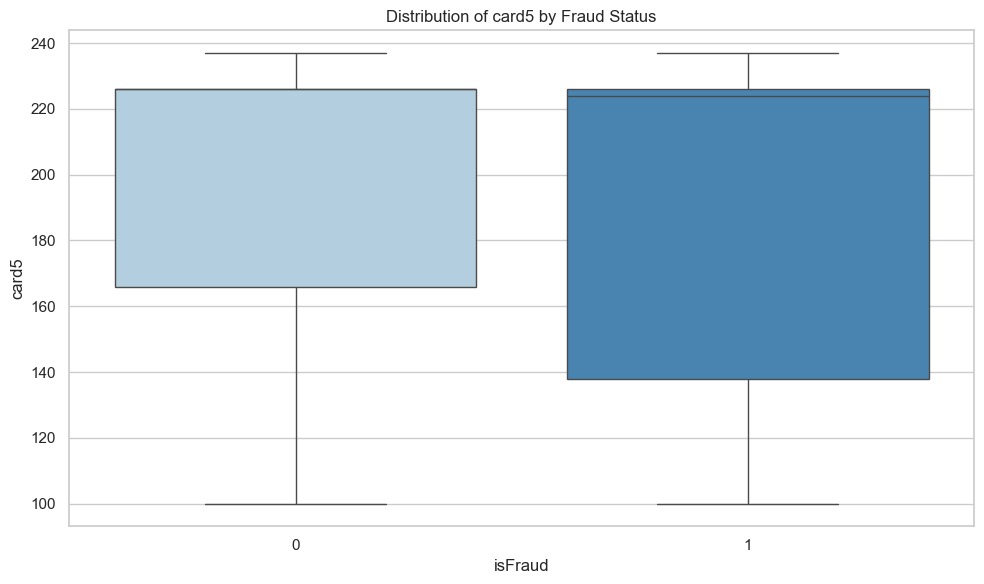

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


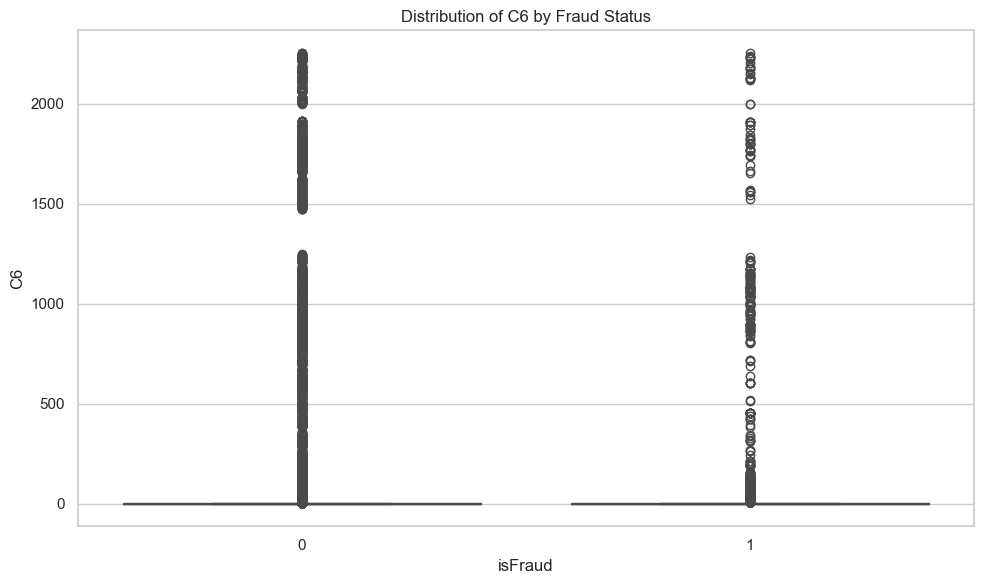

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


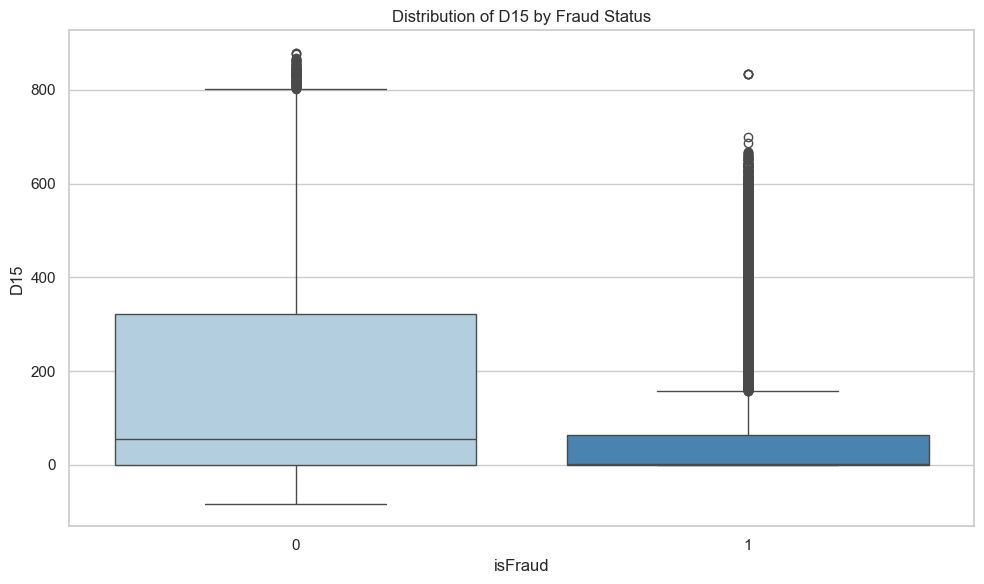

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


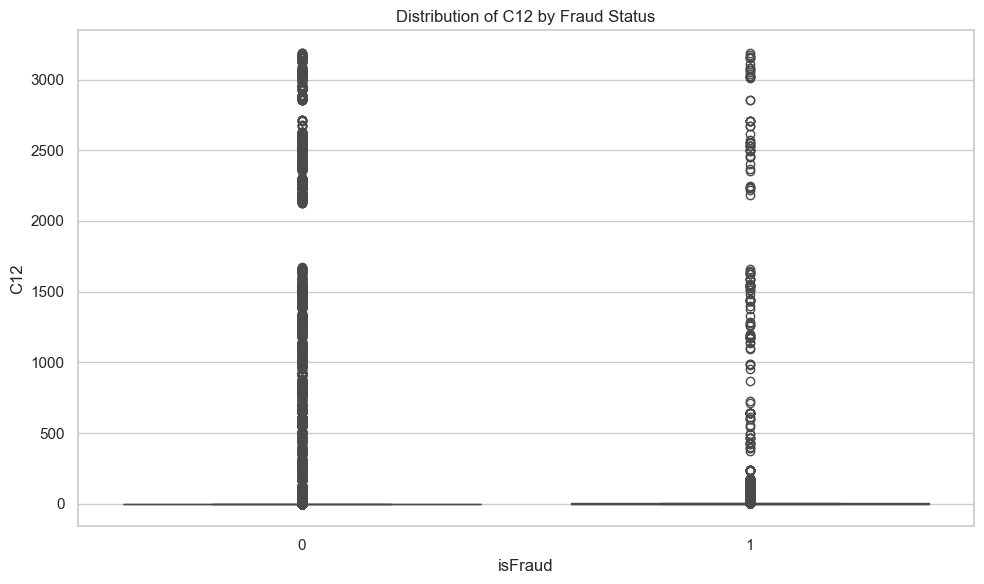

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


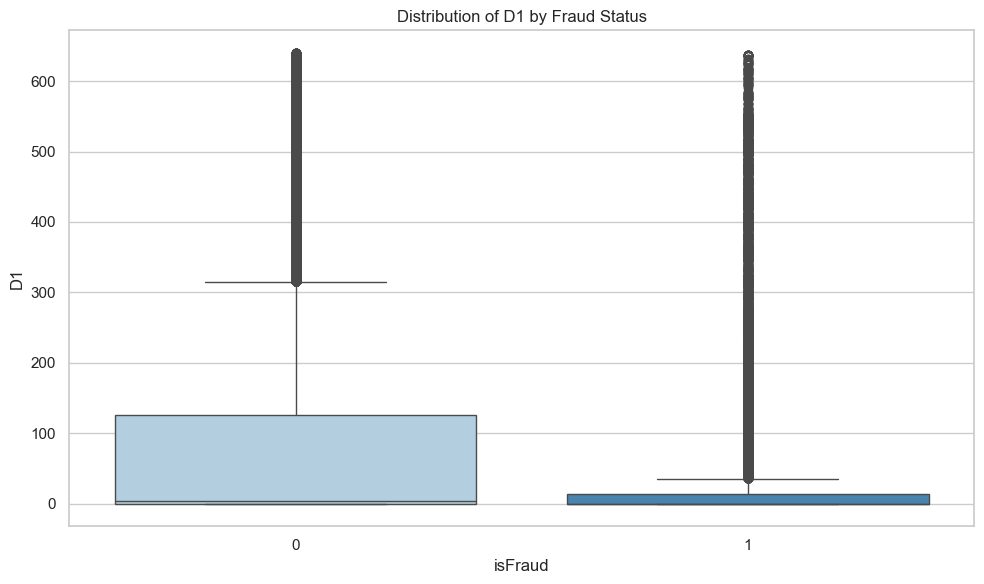

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


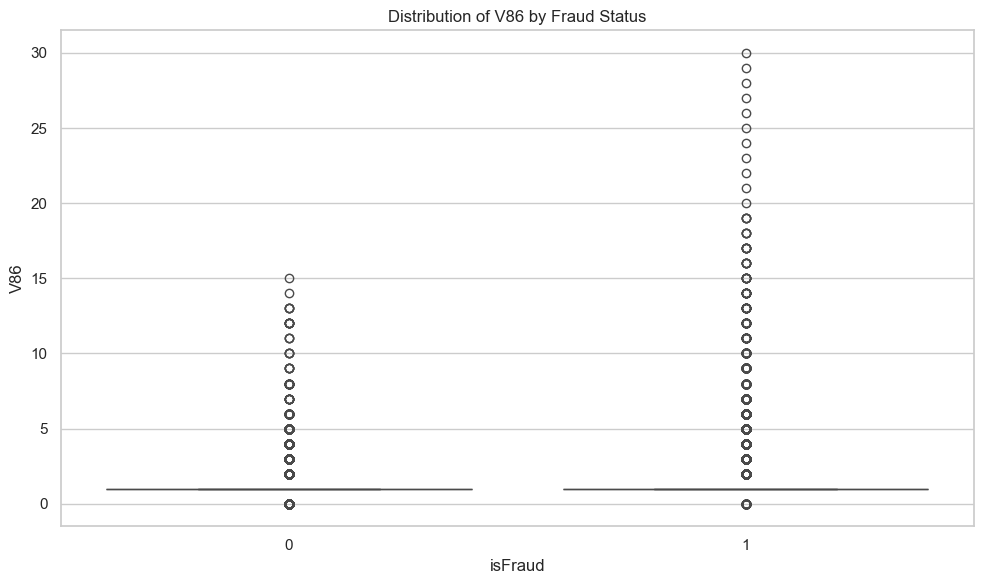

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


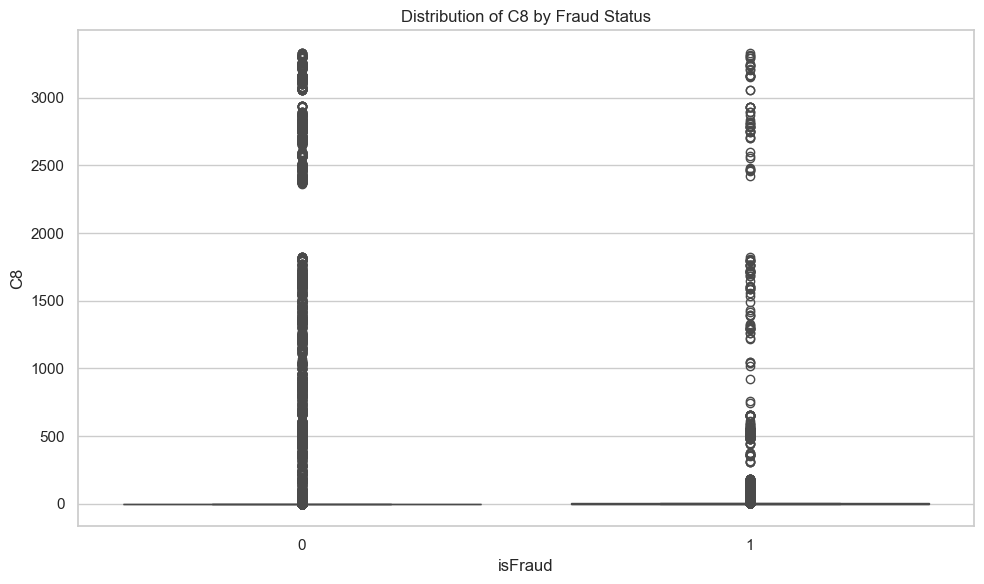

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


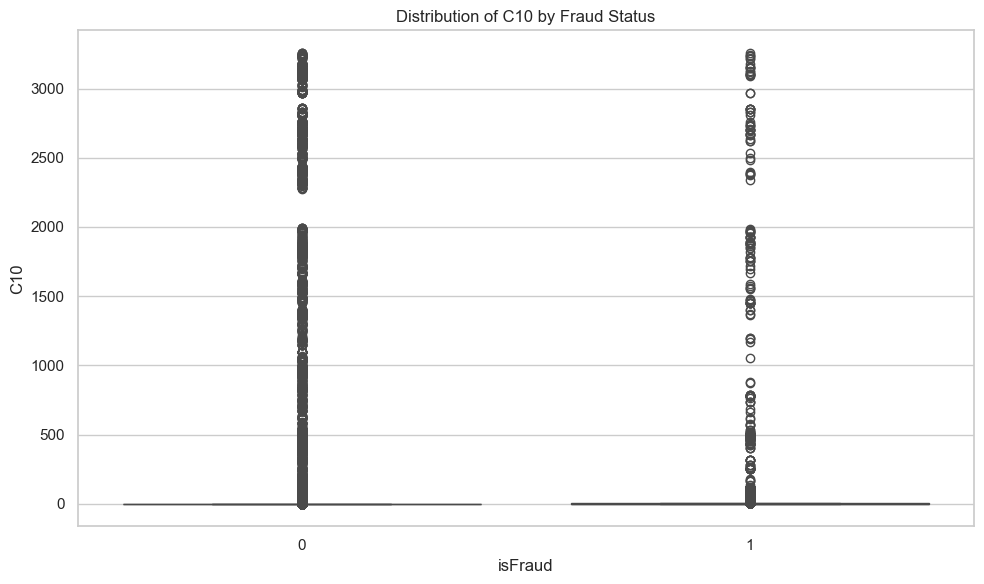

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


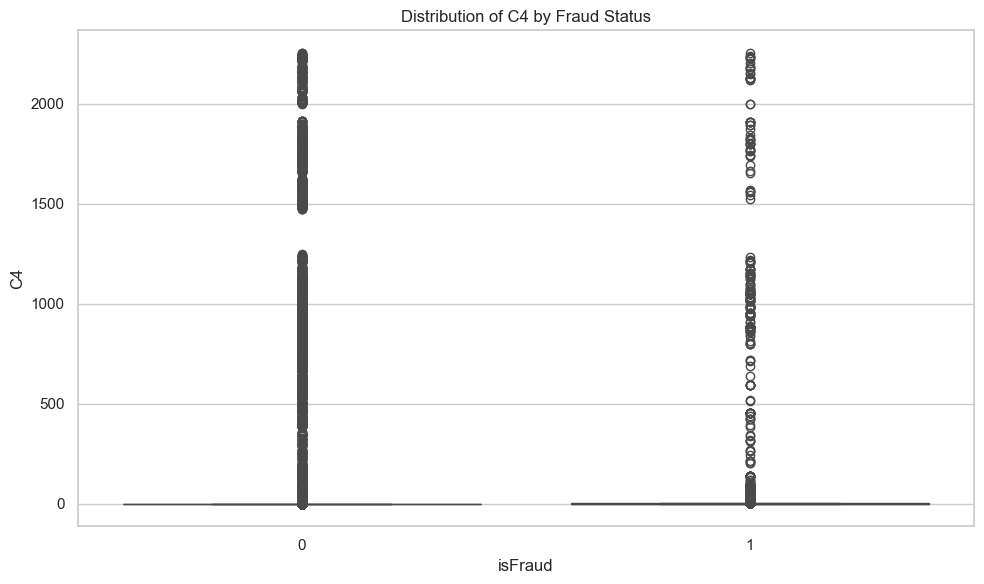

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


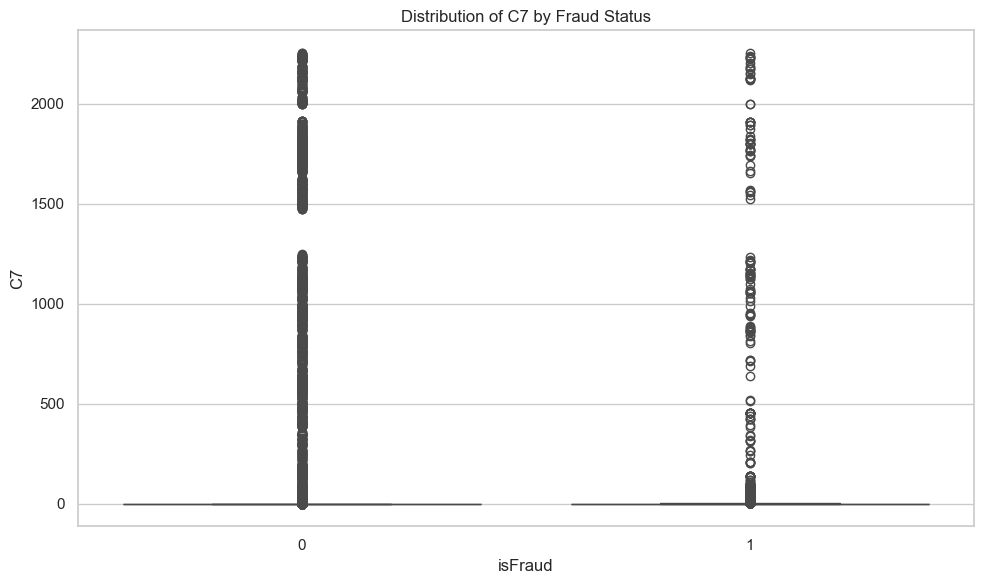

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


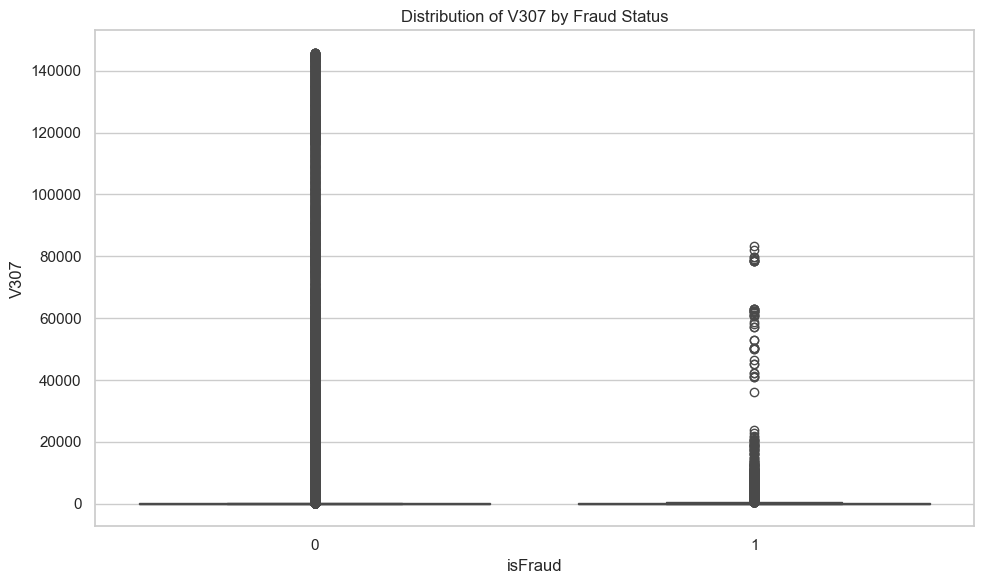

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


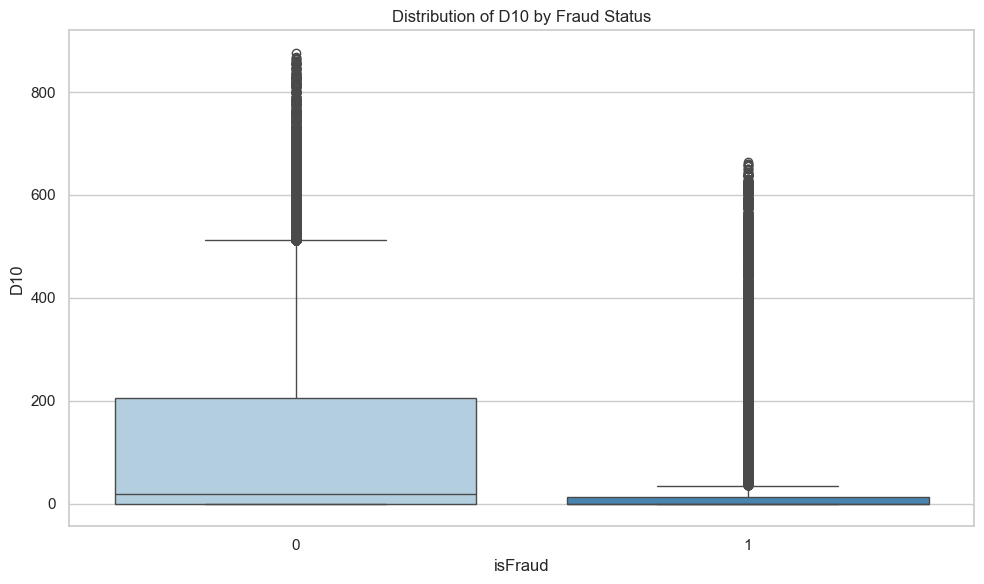

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


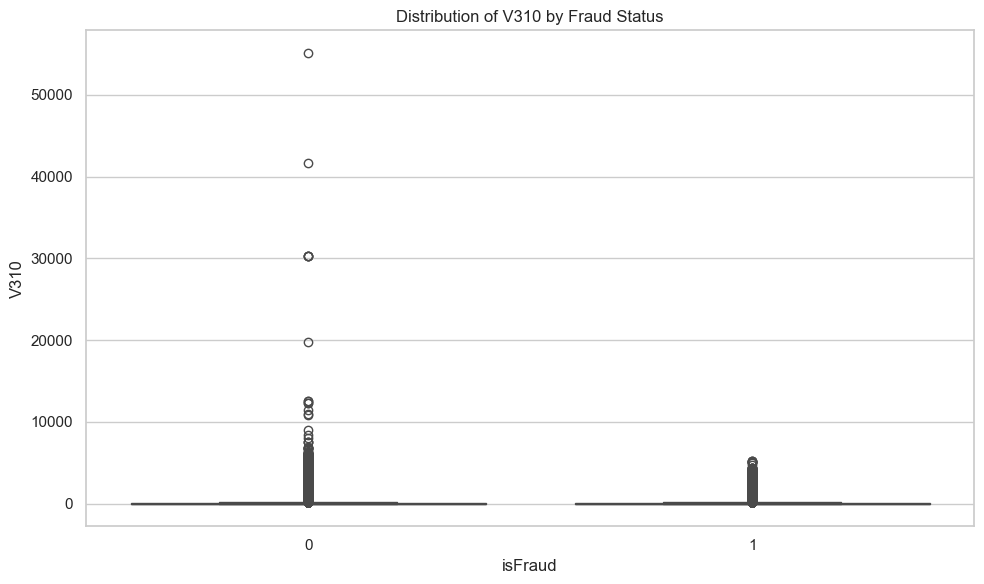

In [ ]:
# top_feature_names = top_features["feature"].values
# top_feature_names = [
#     feature for feature in top_feature_names if feature != "P_emaildomain_gmail.com"
# ]

# data = train[top_feature_names + ["isFraud"]]
# # Exclude 'P_emaildomain_gmail.com' from top_feature_names if it exists

# # Set the plotting style
# sns.set(style="whitegrid")
# # Proceed with the plotting as before
# import matplotlib.pyplot as plt
# import seaborn as sns

# for feature in top_feature_names:
#     plt.figure(figsize=(10, 6))

#     # Determine the plot type based on the variable type
#     if data[feature].dtype == "float64" or data[feature].dtype == "int64":
#         # Continuous Variable: Boxplot
#         sns.boxplot(data=data, x="isFraud", y=feature, palette="Blues")
#         plt.title(f"Distribution of {feature} by Fraud Status")
#     else:
#         # Categorical or dummy Variable: Countplot
#         sns.countplot(data=data, x=feature, hue="isFraud", palette="Blues")
#         plt.title(f"{feature} vs Fraud Count")
#         plt.xticks(rotation=45)

#     plt.tight_layout()
#     plt.show()

Split data and scale. 

In [ ]:
# Separate features and target
X = credit_card_data.drop("Class", axis=1)
y = credit_card_data["Class"]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

The block below can take longer than 5 mins to run depending on you computer specs.

In [ ]:
# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        f"{model.__class__.__name__} Classification Report:\n",
        classification_report(y_test, y_pred),
    )
    print(
        f"{model.__class__.__name__} ROC AUC Score: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])}\n"
    )


# Logistic Regression
logistic_model = LogisticRegression()
evaluate_model(logistic_model, X_train_scaled, y_train, X_test_scaled, y_test)

# Decision Tree
dtree_model = DecisionTreeClassifier()
evaluate_model(dtree_model, X_train, y_train, X_test, y_test)

# Random Forest with parallel processing and fewer estimators
rforest_model = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)
evaluate_model(rforest_model, X_train, y_train, X_test, y_test)

# # Gradient Boosting with fewer estimators
gboost_model = GradientBoostingClassifier(n_estimators=50)
evaluate_model(gboost_model, X_train, y_train, X_test, y_test)

# XGBoost with fewer estimators and parallel processing
xgb_model = XGBClassifier(
    n_estimators=50, eval_metric="logloss", n_jobs=-1, random_state=42
)
evaluate_model(xgb_model, X_train, y_train, X_test, y_test)

In [ ]:
# Define a function to store performance metrics for each model
def evaluate_model_performance(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Check if the model supports predict_proba
    if hasattr(model, "predict_proba"):
        auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    else:
        auc_score = (
            None  # Or use a default score like 0.5 if predict_proba is not available
        )

    f1_score = report["weighted avg"]["f1-score"]
    return auc_score, f1_score


# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(eval_metric="logloss"),
}

# Initialize lists to store results
auc_scores = []
f1_scores = []
model_names = []

# Evaluate each model
for name, model in models.items():
    auc, f1 = evaluate_model_performance(
        model, X_train_scaled, y_train, X_test_scaled, y_test
    )
    auc_scores.append(auc)
    f1_scores.append(f1)
    model_names.append(name)

# Store results in a DataFrame
results = pd.DataFrame(
    {"Model": model_names, "ROC AUC Score": auc_scores, "F1 Score": f1_scores}
)

# Plotting metrics
metrics = {"ROC AUC Score": auc_scores, "F1 Score": f1_scores}
for metric_name, scores in metrics.items():
    plt.figure(figsize=(10, 5))
    plt.plot(model_names, scores, marker="o", label=metric_name)
    plt.xlabel("Model")
    plt.ylabel(metric_name)
    plt.title(f"Model {metric_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Attempt at ALE and Partial Dependence Plots

In [ ]:
# Verify column names match
assert list(X_test.columns) == list(X_encoded.columns), "Column names do not match!"

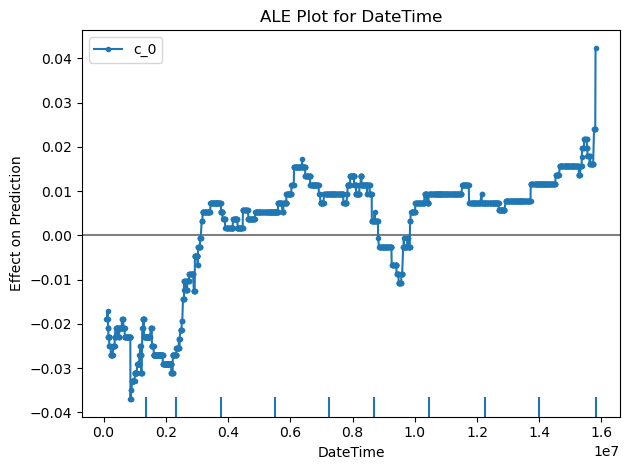

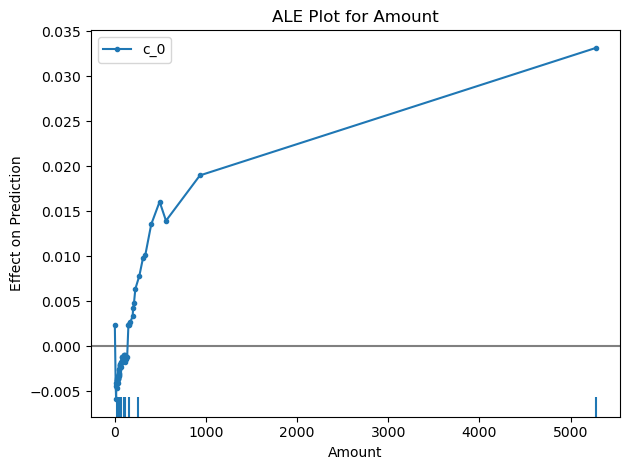

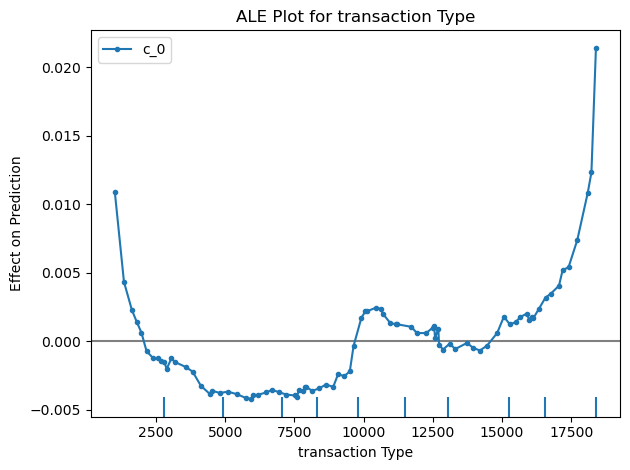

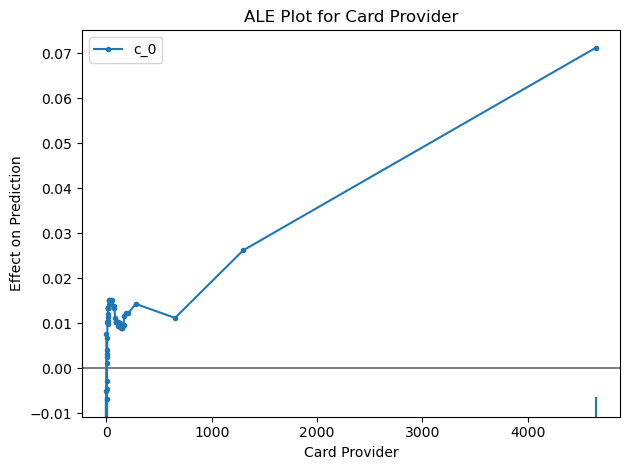

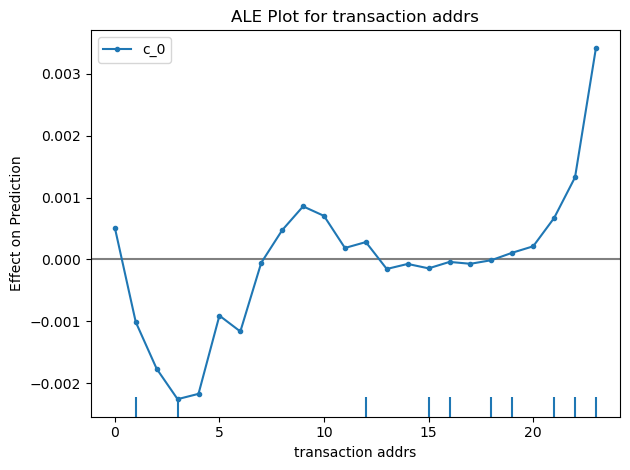

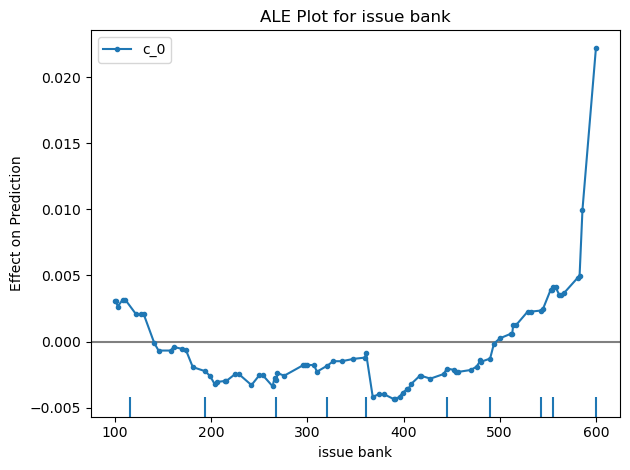

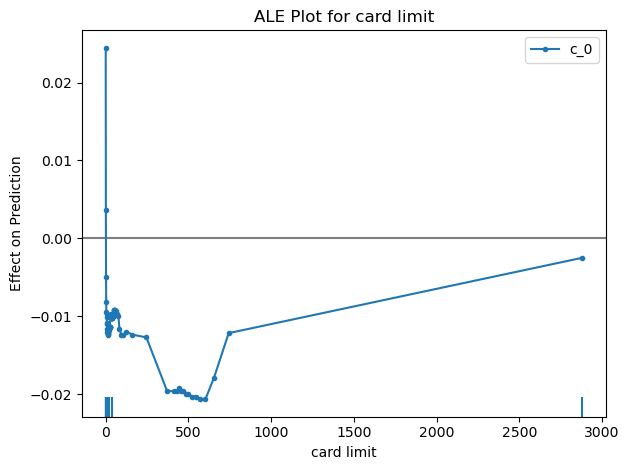

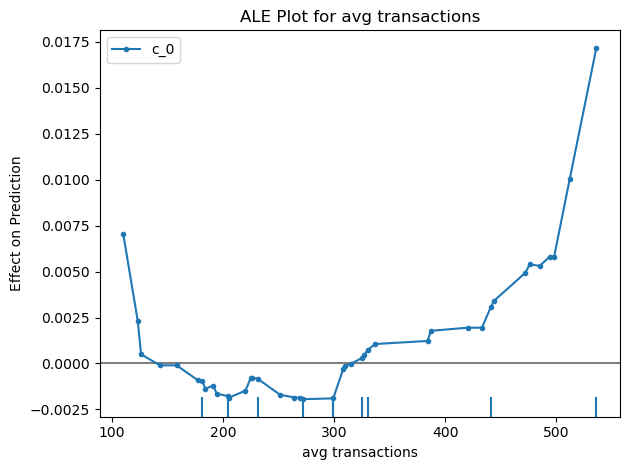

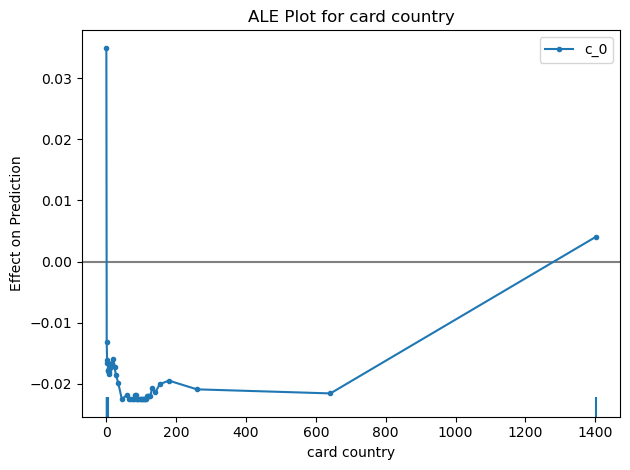

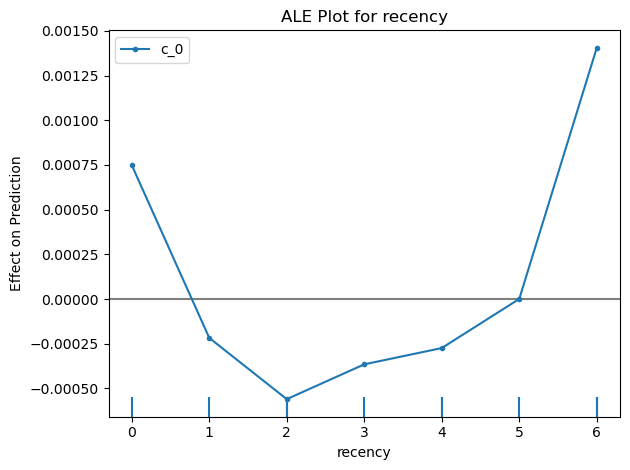

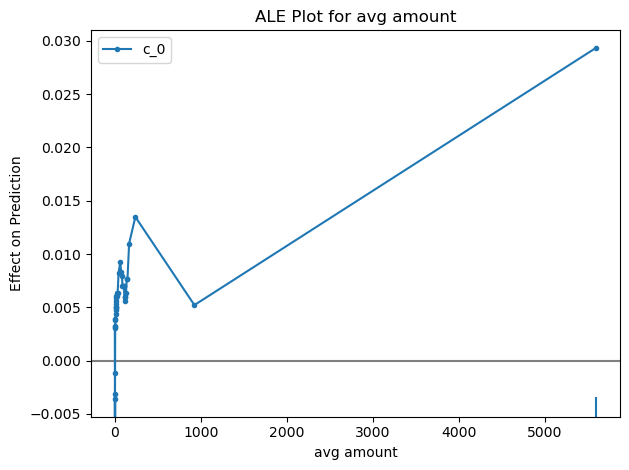

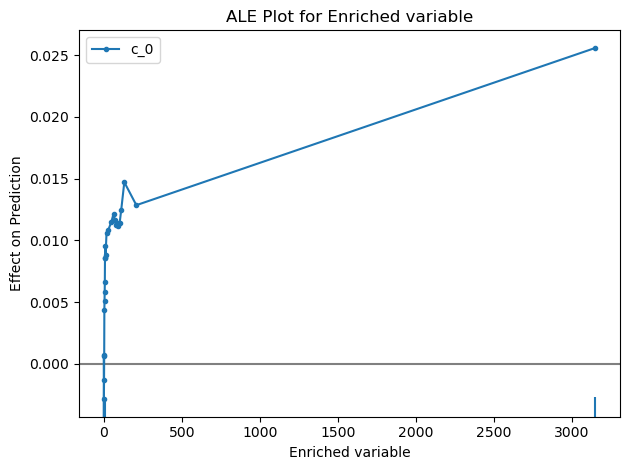

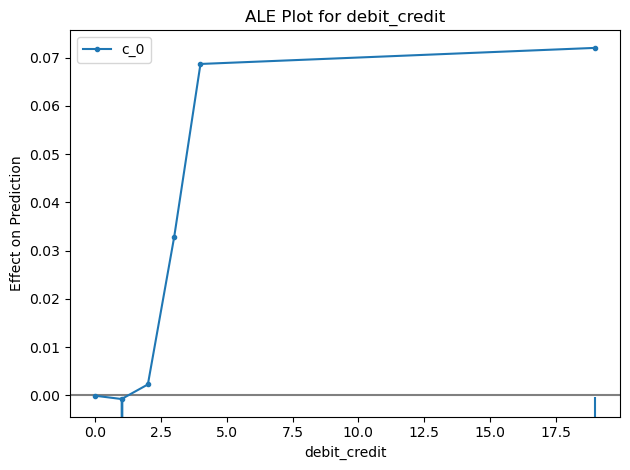

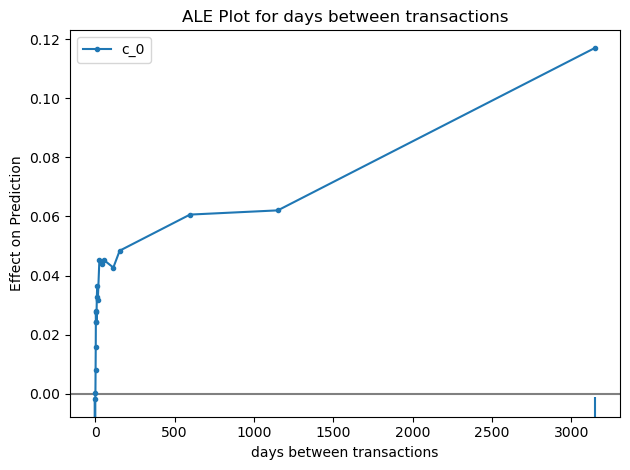

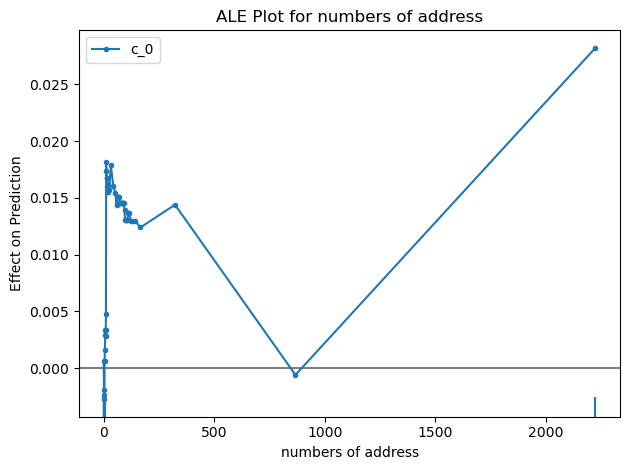

In [ ]:
from alibi.explainers.ale import ALE, plot_ale
import matplotlib.pyplot as plt

# Map the original feature names to the top features
selected_features = [
    "TransactionDT",
    "TransactionAmt",
    "card1",
    "C1",
    "hour",
    "card2",
    "C13",
    "addr1",
    "C14",
    "dayofweek",
    "C2",
    "C11",
    "V87",
    "C12",
    "C6",
]

top_features_names = [
    "DateTime",
    "Amount",
    "transaction Type",
    "Card Provider",
    "transaction addrs",
    "issue bank",
    "card limit",
    "avg transactions",
    "card country",
    "recency",
    "avg amount",
    "Enriched variable",
    "debit_credit",
    "days between transactions",
    "numbers of address",
]

# Create a copy of the test set and sample a smaller subset
X_test_copy = X_test.copy()
X_test_sample = X_test_copy.sample(10_000, random_state=42)  # Sample 2000 rows

# Initialize ALE explainer with all features
ale = ALE(lambda x: rf.predict_proba(x)[:, 1], feature_names=X_test.columns)

# Compute ALE explanation on the sampled dataset
ale_explanation = ale.explain(X_test_sample.values)

# Plot ALE for the top 15 features
for i, feature in enumerate(selected_features):
    feature_idx = [list(X_test.columns).index(feature)]  # Make feature_idx a list
    plot_ale(ale_explanation, features=feature_idx)  # Use plot_ale for visualization
    plt.title(f"ALE Plot for {top_features_names[i]}")
    plt.xlabel(top_features_names[i])
    plt.ylabel("Effect on Prediction")
    plt.tight_layout()
    plt.show()

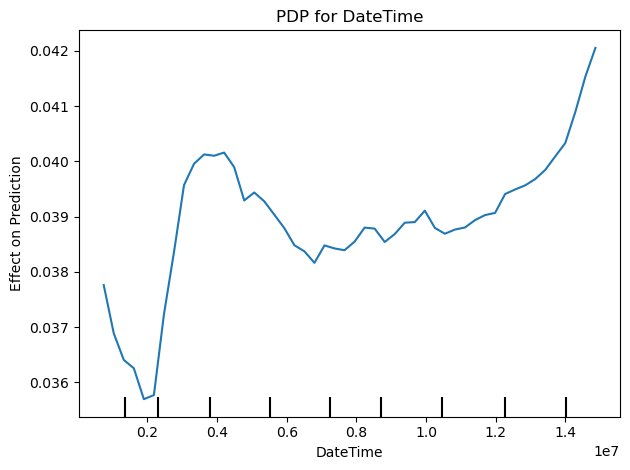

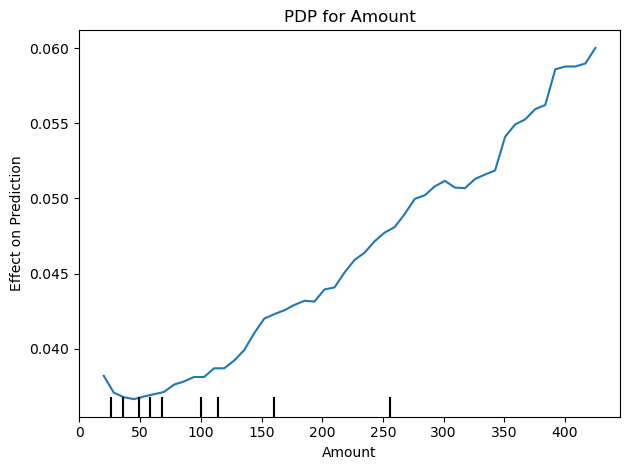

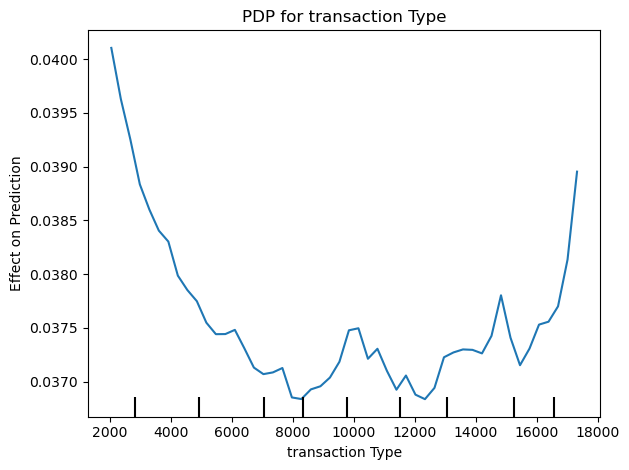

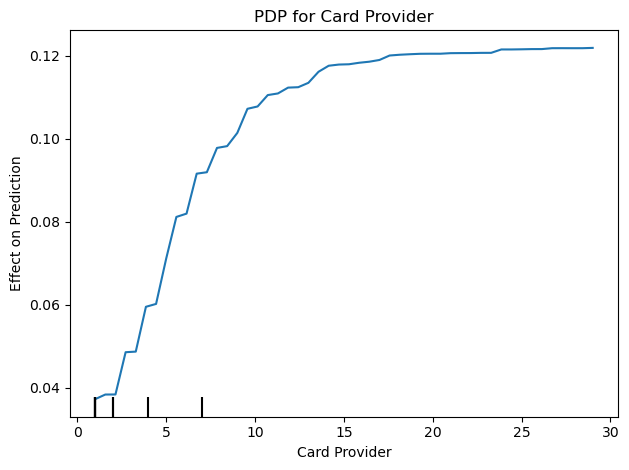

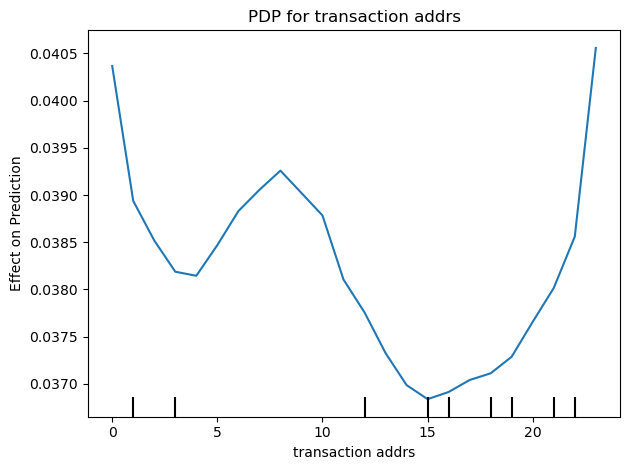

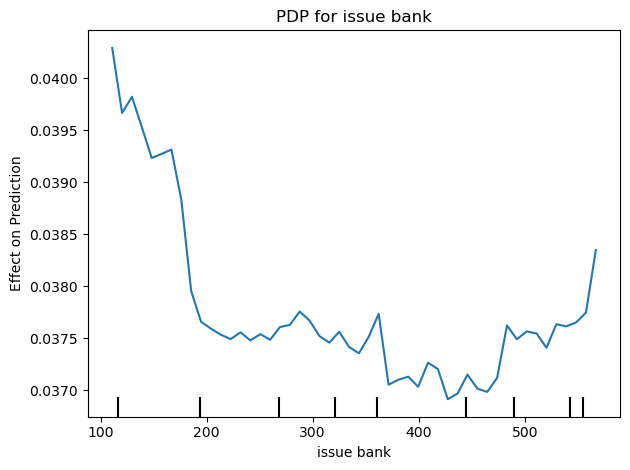

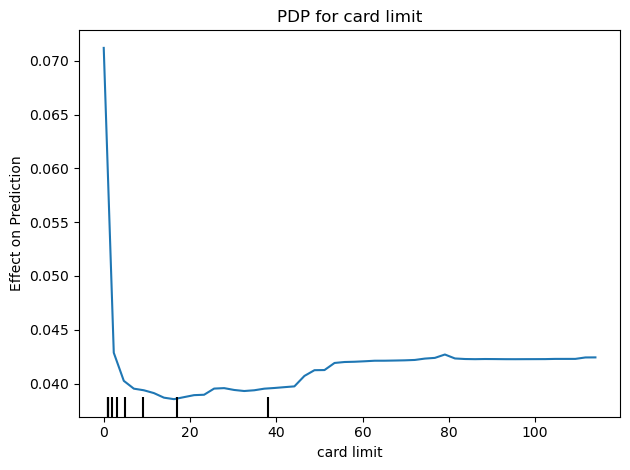

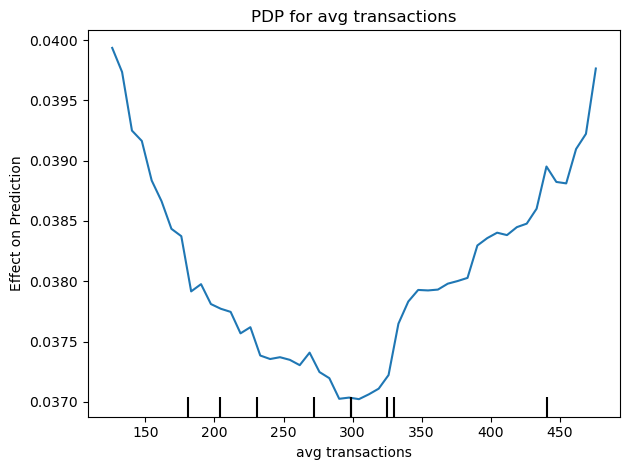

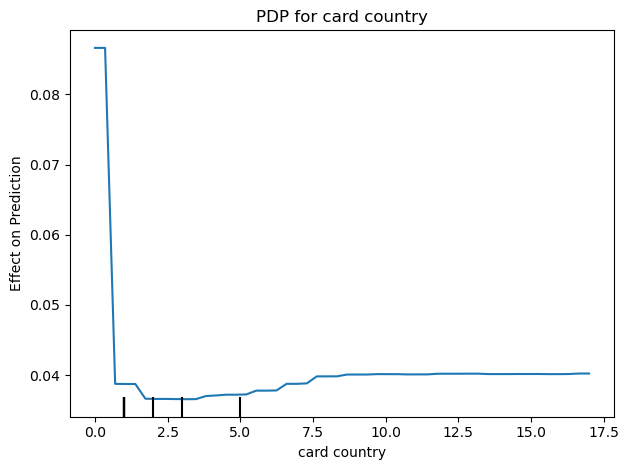

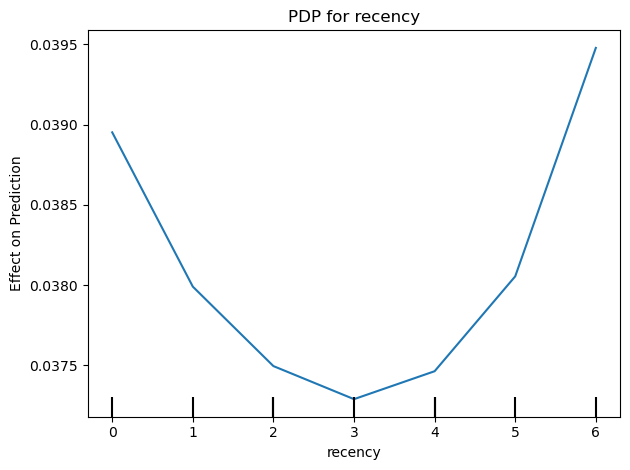

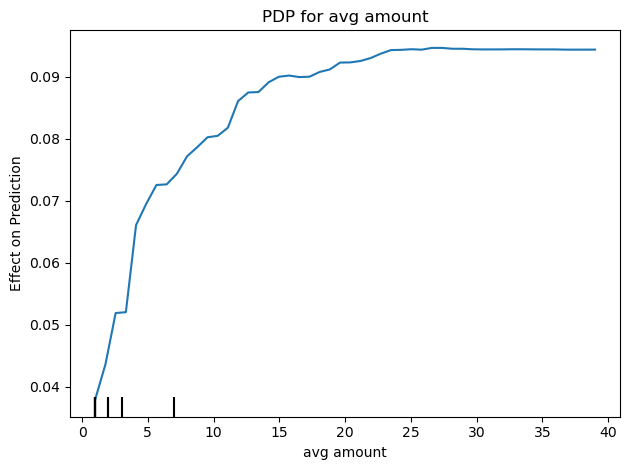

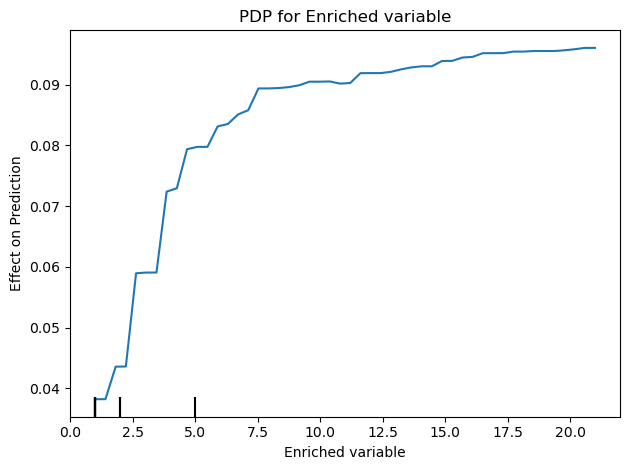

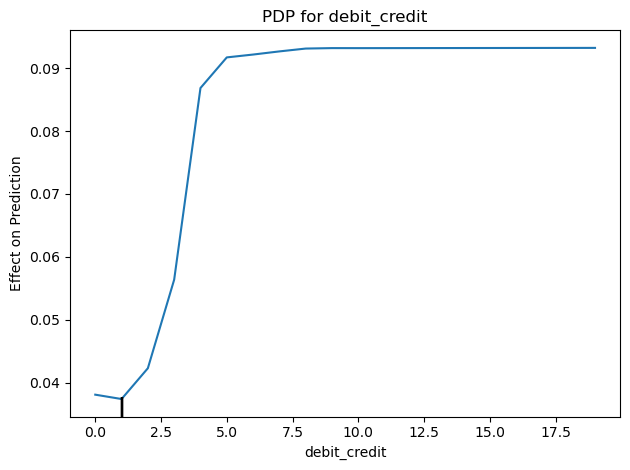

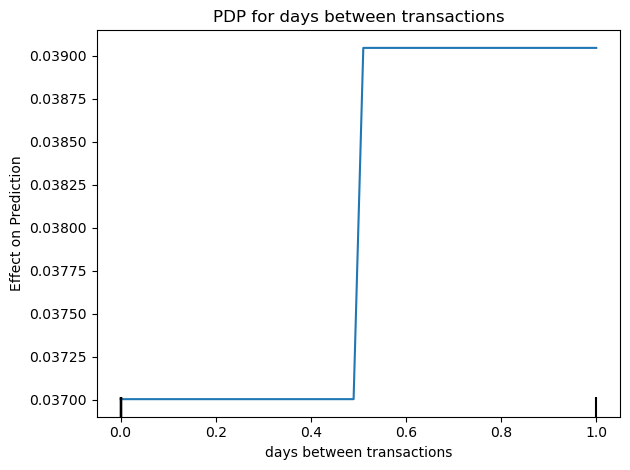

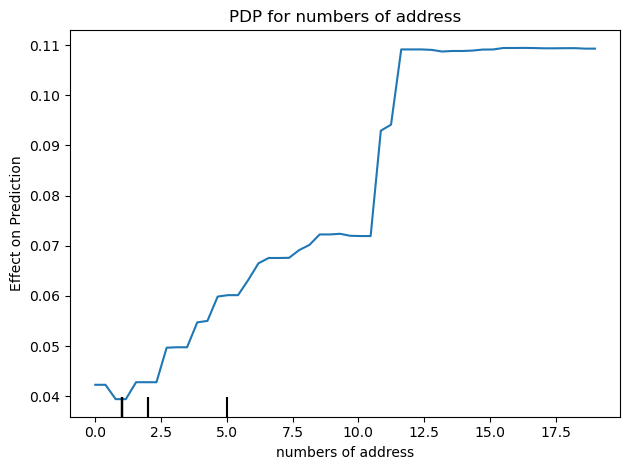

In [ ]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
import matplotlib.pyplot as plt

# Create a copy of the test set and sample a smaller subset
X_test_copy = X_test.copy()
X_test_sample = X_test_copy.sample(10_000, random_state=42)  # Use the same sampled data

# Plot PDP for the top 15 features
for i, feature in enumerate(selected_features):
    feature_idx = list(X_test.columns).index(feature)  # Get the feature index
    PartialDependenceDisplay.from_estimator(
        rf,  # Random Forest model
        X_test_sample,  # Sampled data
        [feature_idx],  # Single feature
        grid_resolution=50,  # Number of evaluation points
    )
    plt.title(f"PDP for {top_features_names[i]}")
    plt.xlabel(top_features_names[i])
    plt.ylabel("Effect on Prediction")
    plt.tight_layout()
    plt.show()